In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [2]:
# trading day list
wind_trading_day = pd.read_csv(
    r"..\data\raw\meta_data\wind_trading_day.csv",
    index_col="Trading_Day",
    parse_dates=True,
)

In [3]:
# spread price continuous data
T_spread_price = pd.read_csv(
    "../data/processed/spread_price/T_spread_price.csv",
    index_col="Trading_Day",
    parse_dates=True,
)
TF_spread_price = pd.read_csv(
    "../data/processed/spread_price/TF_spread_price.csv",
    index_col="Trading_Day",
    parse_dates=True,
)

In [4]:
# start and end date of roll period
T_roll_period = pd.read_csv(
    "../data/processed/roll_period/T_roll_period.csv", index_col="contract"
).astype("datetime64[ns]")
TF_roll_period = pd.read_csv(
    "../data/processed/roll_period/TF_roll_period.csv", index_col="contract"
).astype("datetime64[ns]")

In [5]:
# close price continuous data
T_Close = pd.read_csv(
    "../data/interim/raw_features/T/T_Close.csv", index_col=0, parse_dates=True
)
TF_Close = pd.read_csv(
    "../data/interim/raw_features/TF/TF_Close.csv", index_col=0, parse_dates=True
)

In [6]:
# open interest continuous data
T_Open_Interest = pd.read_csv(
    "../data/interim/raw_features/T/T_Open_Interest.csv", 
    index_col=0, 
    parse_dates=True
)
TF_Open_Interest = pd.read_csv(
    "../data/interim/raw_features/TF/TF_Open_Interest.csv",
    index_col=0,
    parse_dates=True,
)

In [7]:
# volume continuous data
T_Volume = pd.read_csv(
    "../data/interim/raw_features/T/T_Volume.csv", index_col=0, parse_dates=True
)
TF_Volume = pd.read_csv(
    "../data/interim/raw_features/TF/TF_Volume.csv",
    index_col=0,
    parse_dates=True,
)

In [8]:
# list of contract by time sequence
T_contract_list = list(T_Close.columns)
TF_contract_list = list(TF_Close.columns)

In [9]:
def find_next_contract(contract, contract_list):

    contract_sr = pd.Series(index=contract_list)

    if contract in contract_list:
        return contract_sr[contract:].index[1]
    else:
        return None

In [10]:
def convert_to_intention_day(roll_period, wind_trading_day, last_record):
    
    # get the intention day(last day of roll period) of each contract 
    dominant_contract = pd.DataFrame(roll_period["end"].shift(-1))
    dominant_contract.columns = ["intention_day"]
    dominant_contract = dominant_contract.astype("datetime64[ns]")

    num_of_nan = dominant_contract.isna().sum().values[0]
    # delete future contracts
    if num_of_nan > 1:
        dominant_contract = dominant_contract.iloc[: (-1) * (num_of_nan - 1), :]

    dominant_contract = dominant_contract.fillna(last_record)
    # get the next date(notice day) after intention day
    dominant_contract["notice_day"] = [wind_trading_day.loc[x:].index[1] for x in dominant_contract.iloc[:, 0]]
    dominant_contract = dominant_contract.astype(str)

    return dominant_contract

In [11]:
def spread_change_during_roll(spread_price, roll_period, contract_list):

    # roll period from the aspect of active contract
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active["spread_change"] = np.nan

    for active_contract in roll_period_for_active.index:
        # the deferred contract is the next contract after active contract
        deferred_contract = find_next_contract(active_contract, contract_list)
        start_date = roll_period_for_active.loc[active_contract, "start"]
        end_date = roll_period_for_active.loc[active_contract, "end"]
        # deferred contract becomes active after the roll period
        assert spread_price.loc[start_date, "active_contract"] == active_contract
        assert spread_price.loc[start_date, "deferred_contract"] == deferred_contract
        assert spread_price.loc[end_date, "active_contract"] == active_contract
        assert spread_price.loc[end_date, "deferred_contract"] == deferred_contract

        # spread change is the change of difference between acitve price and deferred price during the roll period
        spread_change = (spread_price.loc[end_date, "spread_price"] - spread_price.loc[start_date, "spread_price"])
        roll_period_for_active.loc[active_contract, "spread_change"] = spread_change
        spread_price.loc[start_date:end_date, "spread_price"].plot()
        plt.title(active_contract)
        plt.show()

    return pd.DataFrame(roll_period_for_active["spread_change"])

In [12]:
def treasury_futures_contracts_sequence(delivery_info):
    
    active_contracts = delivery_info.index.to_series()[:-1].values.reshape(-1, 1)
    deferred_contracts = delivery_info.index.to_series()[1:].values.reshape(-1, 1)
    # further contract is the next contract after deferred contract
    further_contracts = np.append(delivery_info.index.to_series().values[2:], None).reshape(-1, 1)
    
    notice_day = delivery_info["notice_day"].values[:-1].reshape(-1, 1)
    # gather info
    active_deferred_contracts = np.concatenate([active_contracts, deferred_contracts, further_contracts, notice_day], axis=1)
    # create dataframe
    contracts_sequence_df = pd.DataFrame(
        data=active_deferred_contracts,
        index=delivery_info["intention_day"][:-1],
        columns=[
            "active_contract",
            "deferred_contract",
            "further_contract",
            "notice_day",
        ],
    )

    return contracts_sequence_df

In [13]:
# get continuous data of the assigned value
def get_value_df(contracts_sequence, value, value_name, contract_list):

    value_df = pd.DataFrame(
        columns=[
            "active_contract",
            "deferred_contract",
            "further_contract",
            "active_contract_" + value_name,
            "deferred_contract_" + value_name,
            "further_contract_" + value_name,
        ]
    )
    # get the notice day of last active contract
    # if last active contract is the first contract, then the last notice day is the first trading day
    for i in range(len(contracts_sequence)):
        if i == 0:
            last_notice_day = value.index[0]
        else:
            last_notice_day = contracts_sequence["notice_day"][i - 1]

        intention_day = contracts_sequence.index[i]
        active_contract_code = contracts_sequence["active_contract"][i]
        deferred_contract_code = contracts_sequence["deferred_contract"][i]
        further_contract_code = find_next_contract(deferred_contract_code, contract_list)
        
        # if the current active contract is not the last active contract, the contract is active from the last notice day to intention day
        if pd.to_datetime(intention_day) <= value.index[-1]:
            current_active_contract_value = value.loc[last_notice_day:intention_day, active_contract_code]
            current_deferred_contract_value = value.loc[last_notice_day:intention_day, deferred_contract_code]
            current_further_contract_value = value.loc[last_notice_day:intention_day, further_contract_code]
            active_contract_code_series = pd.Series(data=active_contract_code, index=current_active_contract_value.index)
            deferred_contract_code_series = pd.Series(data=deferred_contract_code, index=current_deferred_contract_value.index)
            further_contract_code_series = pd.Series(data=further_contract_code, index=current_further_contract_value.index)
        # if the last active contract in contracts sequence is the current active contract, the contract is active since the last notice day
        else:
            current_active_contract_value = value.loc[last_notice_day:, active_contract_code]
            current_deferred_contract_value = value.loc[last_notice_day:, deferred_contract_code]
            current_further_contract_value = value.loc[last_notice_day:, further_contract_code]

            if current_active_contract_value is not None: # check if there is any record of the last contract
                active_contract_code_series = pd.Series(data=active_contract_code, index=current_active_contract_value.index)
                deferred_contract_code_series = pd.Series(data=deferred_contract_code,index=current_deferred_contract_value.index)
                further_contract_code_series = pd.Series(data=further_contract_code,index=current_further_contract_value.index)

        current_data = pd.concat(
            [
                active_contract_code_series,
                deferred_contract_code_series,
                further_contract_code_series,
                current_active_contract_value,
                current_deferred_contract_value,
                current_further_contract_value,
            ],
            axis=1,
        )
        current_data.columns = value_df.columns
        value_df = pd.concat([value_df, current_data], axis=0)

    last_intention_date = pd.to_datetime(intention_day)
    # if the last contract is not the current active contract, that means the current contract is not in the active contract list
    # add information about the current active contract and corresponding deferred contract
    if last_intention_date < value.index[-1]:

        current_contract = contracts_sequence.loc[intention_day, "deferred_contract"]
        next_contract = find_next_contract(current_contract, contract_list)
        further_contract = find_next_contract(next_contract, contract_list)

        latest_active_contract_value = value.loc[last_intention_date:, current_contract].iloc[1:]
        latest_deferred_contract_value = value.loc[last_intention_date:, next_contract].iloc[1:]
        latest_further_contract_value = value.loc[last_intention_date:, further_contract].iloc[1:]

        active_contract_code_series = pd.Series(data=current_contract, index=latest_active_contract_value.index)
        deferred_contract_code_series = pd.Series(data=next_contract, index=latest_deferred_contract_value.index)
        further_contract_code_series = pd.Series(data=further_contract, index=latest_further_contract_value.index)

        current_data = pd.concat(
            [
                active_contract_code_series,
                deferred_contract_code_series,
                further_contract_code_series,
                latest_active_contract_value,
                latest_deferred_contract_value,
                latest_further_contract_value,
            ],
            axis=1,
        )
        current_data.columns = value_df.columns

        value_df = pd.concat([value_df, current_data], axis=0)

    value_df.index.name = "Trading_Day"

    return value_df

In [14]:
T_last_record = T_Close.index[-1]
T_dominant_contract = convert_to_intention_day(
    T_roll_period, wind_trading_day, T_last_record
)
TF_last_record = TF_Close.index[-1]
TF_dominant_contract = convert_to_intention_day(
    TF_roll_period, wind_trading_day, TF_last_record
)

T_contracts_sequence = treasury_futures_contracts_sequence(T_dominant_contract)
TF_contracts_sequence = treasury_futures_contracts_sequence(TF_dominant_contract)

In [17]:
T_contracts_sequence.to_csv('../data/processed/roll_period/T_contracts_sequence.csv')
TF_contracts_sequence.to_csv('../data/processed/roll_period/TF_contracts_sequence.csv')

## Spread Price Change

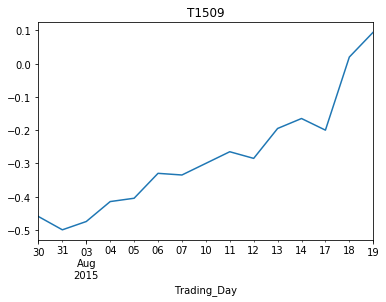

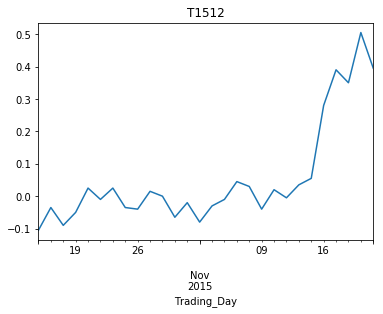

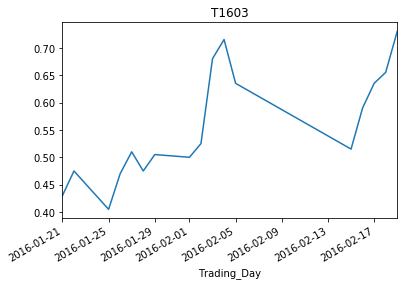

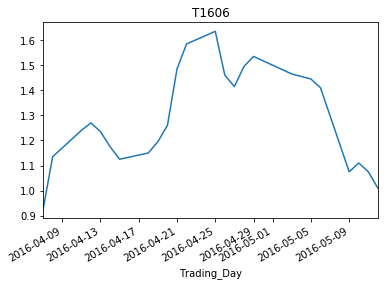

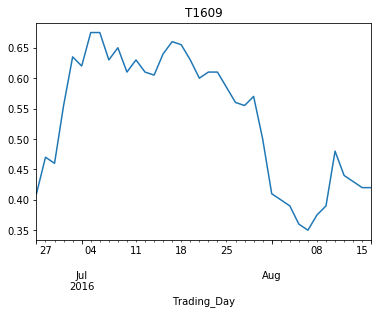

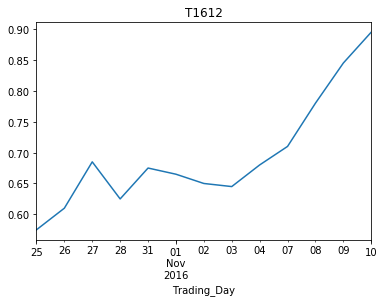

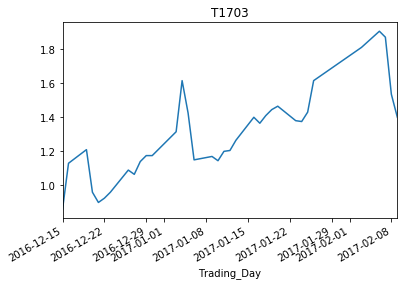

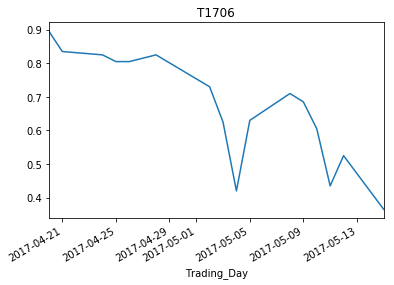

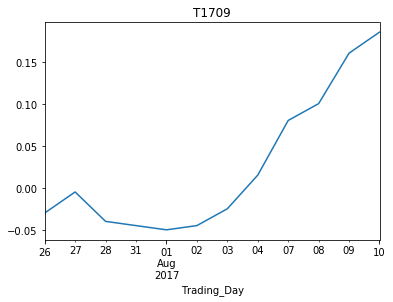

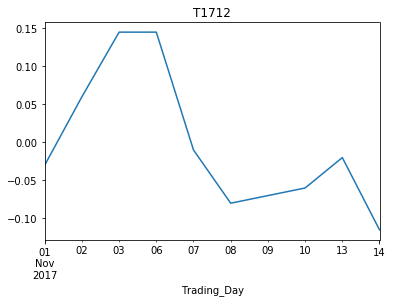

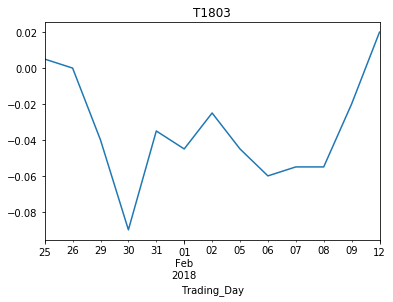

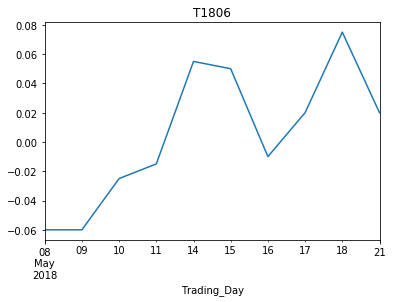

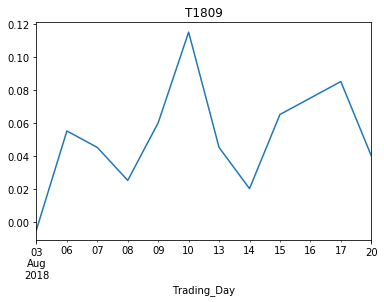

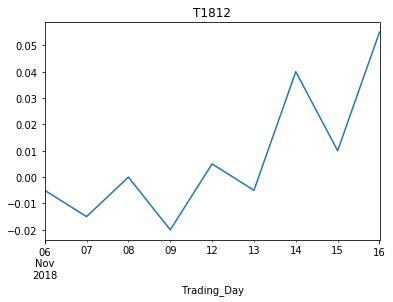

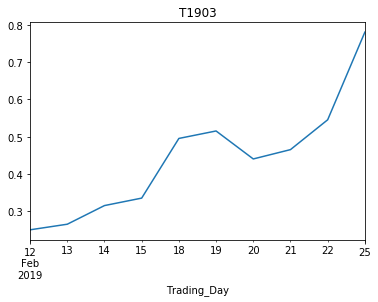

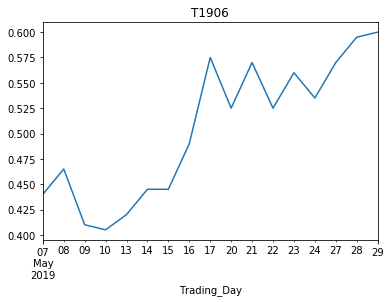

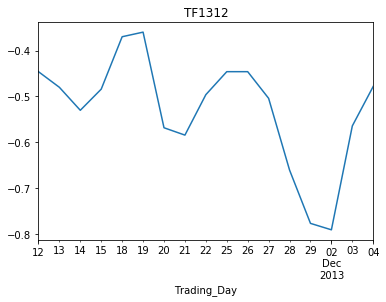

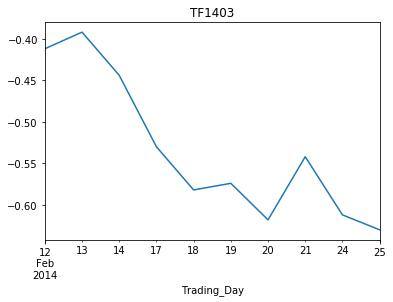

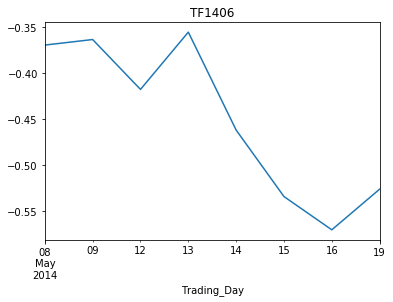

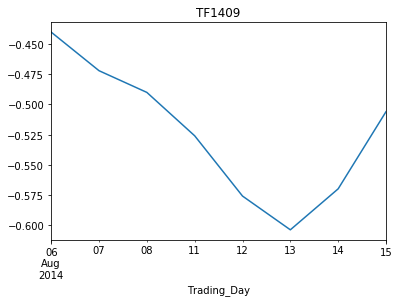

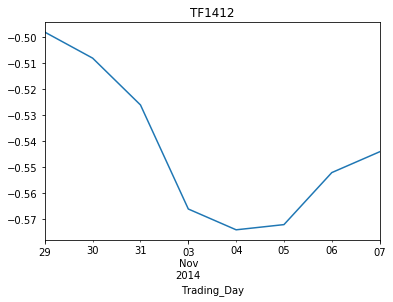

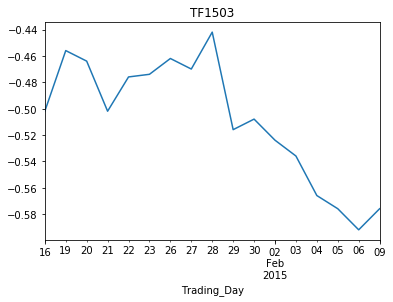

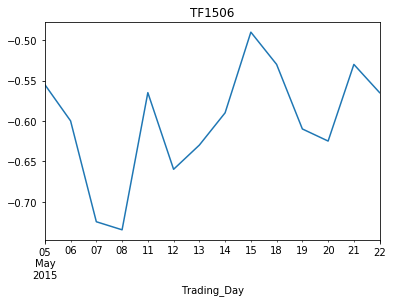

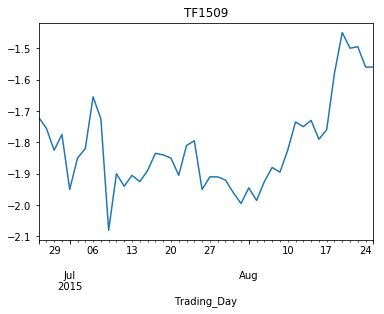

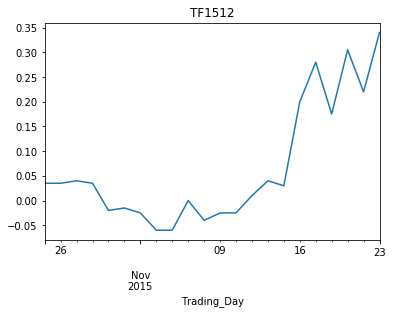

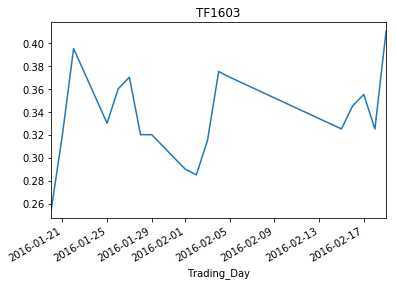

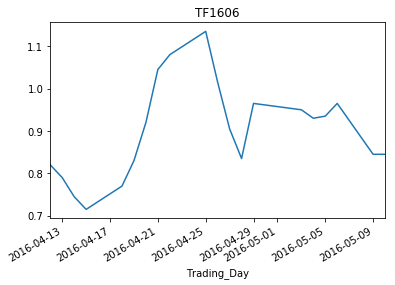

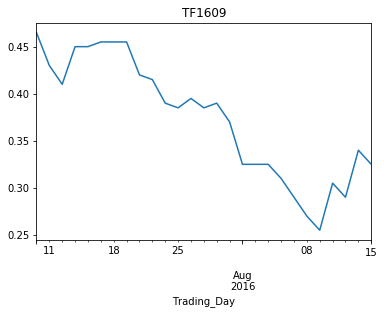

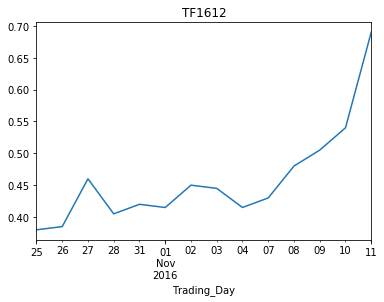

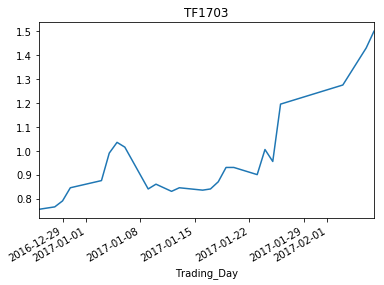

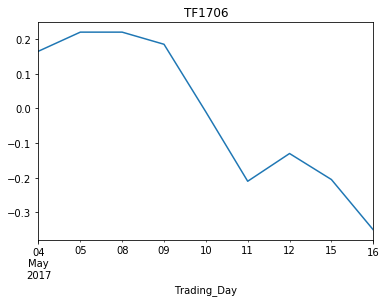

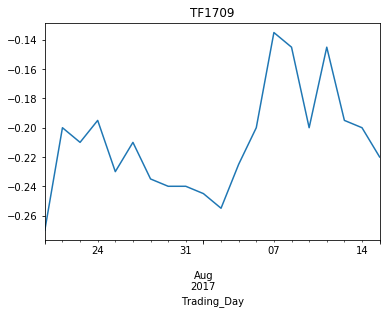

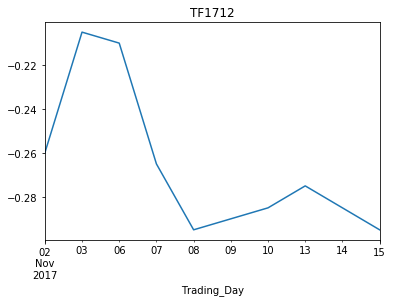

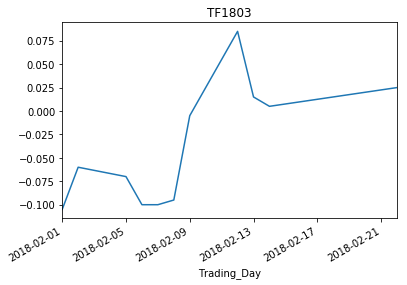

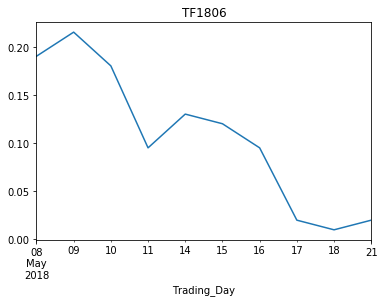

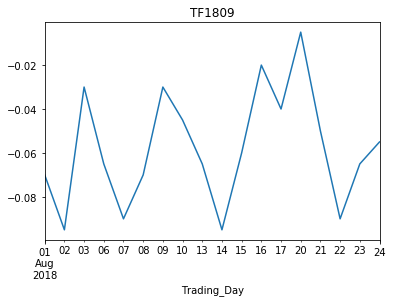

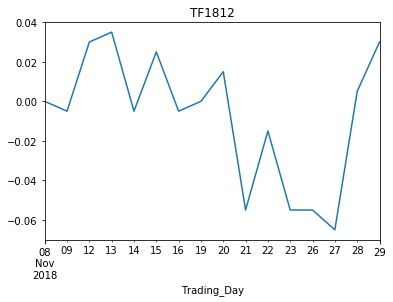

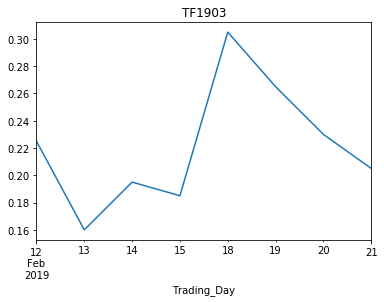

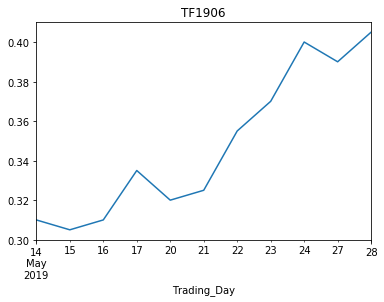

In [19]:
T_spread_change = spread_change_during_roll(T_spread_price, T_roll_period, T_contract_list)
TF_spread_change = spread_change_during_roll(TF_spread_price, TF_roll_period, TF_contract_list)

In [20]:
T_spread_change

,spread_change
contract,
T1509,0.555
T1512,0.500
T1603,0.300
T1606,0.085
T1609,0.010
T1612,0.320
T1703,0.540
T1706,-0.530
T1709,0.215


## Create Feature DataFrame

In [16]:
T_features = pd.DataFrame()
TF_features = pd.DataFrame()

In [17]:
# add new feature to the feature dataframe, if the feature already exists, replace it with the new value
def add_feature(features, new_feature):
    if new_feature.columns[0] not in features.columns:
        features = pd.concat([features, new_feature], axis=1)
    else:
        features = features.drop(new_feature.columns[0], axis=1)
        features = pd.concat([features, new_feature], axis=1)
        
    return features

## 1 Spread 5d Change

In [18]:
# calculate the spread change right before roll period of the assigned length
def spread_change_before_roll(days, spread_price, roll_period, contract_list):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days) + "d_spread_change"] = np.nan

    for active_contract in roll_period_for_active.index:

        deferred_contract = find_next_contract(active_contract, contract_list)
        # the start date of the roll period, in this case, it is the last date of the considered period
        start_date = roll_period_for_active.loc[active_contract, "start"]
        # the begin date of the considered period, days means days before the roll period
        begin_date = spread_price.loc[:start_date, :].index[-1 * days]

        assert spread_price.loc[begin_date, "active_contract"] == active_contract
        assert spread_price.loc[begin_date, "deferred_contract"] == deferred_contract
        assert spread_price.loc[start_date, "active_contract"] == active_contract
        assert spread_price.loc[start_date, "deferred_contract"] == deferred_contract
        # the change of spread during the period
        spread_change = (spread_price.loc[start_date, "spread_price"] - spread_price.loc[begin_date, "spread_price"])
        roll_period_for_active.loc[active_contract, str(days) + "d_spread_change"] = spread_change

    return pd.DataFrame(roll_period_for_active[str(days) + "d_spread_change"])

In [18]:
# get the continuous price
T_price_conti = get_value_df(T_contracts_sequence, T_Close, "price", T_contract_list)
T_price_conti["spread_price"] = T_price_conti["active_contract_price"] - T_price_conti["deferred_contract_price"]
T_price_conti.head()

,active_contract,deferred_contract,further_contract,active_contract_price,deferred_contract_price,further_contract_price,spread_price
Trading_Day,,,,,,,
2015-03-20,T1509,T1512,T1603,97.09,97.435,97.785,-0.345
2015-03-23,T1509,T1512,T1603,97.02,97.435,97.100,-0.415
2015-03-24,T1509,T1512,T1603,96.92,97.435,97.580,-0.515
2015-03-25,T1509,T1512,T1603,96.85,97.500,97.580,-0.650
2015-03-26,T1509,T1512,T1603,96.37,97.000,97.580,-0.630


In [20]:
T_spread_5d_change = spread_change_before_roll(
    5, T_price_conti, T_roll_period, T_contract_list
)
T_spread_10d_change = spread_change_before_roll(
    10, T_price_conti, T_roll_period, T_contract_list
)
T_spread_15d_change = spread_change_before_roll(
    15, T_price_conti, T_roll_period, T_contract_list
)
T_spread_20d_change = spread_change_before_roll(
    20, T_price_conti, T_roll_period, T_contract_list
)

In [21]:
TF_price_conti = get_value_df(TF_contracts_sequence, TF_Close, "price", TF_contract_list)
TF_price_conti["spread_price"] = (TF_price_conti["active_contract_price"] - TF_price_conti["deferred_contract_price"])
TF_price_conti.head()

,active_contract,deferred_contract,further_contract,active_contract_price,deferred_contract_price,further_contract_price,spread_price
Trading_Day,,,,,,,
2013-09-06,TF1312,TF1403,TF1406,94.170,94.288,94.344,-0.118
2013-09-09,TF1312,TF1403,TF1406,93.906,94.000,94.070,-0.094
2013-09-10,TF1312,TF1403,TF1406,93.842,93.930,94.008,-0.088
2013-09-11,TF1312,TF1403,TF1406,93.598,93.688,93.766,-0.090
2013-09-12,TF1312,TF1403,TF1406,93.728,93.842,93.926,-0.114


In [22]:
TF_spread_5d_change = spread_change_before_roll(
    5, TF_price_conti, TF_roll_period, TF_contract_list
)
TF_spread_10d_change = spread_change_before_roll(
    10, TF_price_conti, TF_roll_period, TF_contract_list
)
TF_spread_15d_change = spread_change_before_roll(
    15, TF_price_conti, TF_roll_period, TF_contract_list
)
TF_spread_20d_change = spread_change_before_roll(
    20, TF_price_conti, TF_roll_period, TF_contract_list
)

In [23]:
T_features = add_feature(T_features, T_spread_5d_change)
TF_features = add_feature(TF_features, TF_spread_5d_change)
T_features

,5d_spread_change
contract,
T1509,0.040
T1512,-0.110
T1603,0.070
T1606,0.095
T1609,-0.185
T1612,0.215
T1703,0.185
T1706,0.100
T1709,-0.050


In [24]:
T_features = add_feature(T_features, T_spread_10d_change)
TF_features = add_feature(TF_features, TF_spread_10d_change)
T_features

,5d_spread_change,10d_spread_change
contract,,
T1509,0.040,1.421085e-14
T1512,-0.110,-9.500000e-02
T1603,0.070,2.550000e-01
T1606,0.095,1.650000e-01
T1609,-0.185,-3.950000e-01
T1612,0.215,1.900000e-01
T1703,0.185,4.500000e-02
T1706,0.100,-2.000000e-02
T1709,-0.050,-6.000000e-02


In [25]:
T_features = add_feature(T_features, T_spread_15d_change)
TF_features = add_feature(TF_features, TF_spread_15d_change)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change
contract,,,
T1509,0.040,1.421085e-14,0.075
T1512,-0.110,-9.500000e-02,0.030
T1603,0.070,2.550000e-01,0.285
T1606,0.095,1.650000e-01,0.150
T1609,-0.185,-3.950000e-01,-0.385
T1612,0.215,1.900000e-01,0.225
T1703,0.185,4.500000e-02,0.190
T1706,0.100,-2.000000e-02,-0.050
T1709,-0.050,-6.000000e-02,-0.050


In [26]:
T_features = add_feature(T_features, T_spread_20d_change)
TF_features = add_feature(TF_features, TF_spread_20d_change)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change
contract,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14
T1603,0.070,2.550000e-01,0.285,2.950000e-01
T1606,0.095,1.650000e-01,0.150,1.150000e-01
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01
T1612,0.215,1.900000e-01,0.225,2.000000e-01
T1703,0.185,4.500000e-02,0.190,3.400000e-01
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01


## 2 Act Price 10d Exp Mva

In [27]:
# calculate the exponential moving average 
def exp_mva(days, price, roll_period, contract_list, name):
    # including price on that day
    price_emva = price.ewm(span=days).mean()

    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days) + name] = np.nan

    for active_contract in roll_period_for_active.index:

        deferred_contract = find_next_contract(active_contract, contract_list)
        start_date = roll_period_for_active.loc[active_contract, "start"]

        roll_period_for_active.loc[active_contract, str(days) + name] = price_emva[start_date]

    return pd.DataFrame(roll_period_for_active[str(days) + name])

In [28]:
# calculate 10 days exponential moving average of the active price
T_act_price_10d_exp_mva = exp_mva(
    10, 
    T_price_conti["active_contract_price"], 
    T_roll_period, 
    T_contract_list,
    'd_act_price_exp_mva'
)

TF_act_price_10d_exp_mva = exp_mva(
    10, 
    TF_price_conti["active_contract_price"], 
    TF_roll_period, 
    TF_contract_list,
    'd_act_price_exp_mva'
)

In [29]:
T_features = add_feature(T_features, T_act_price_10d_exp_mva)
TF_features = add_feature(TF_features, TF_act_price_10d_exp_mva)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva
contract,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014


## 3 Corr Btwn Act Price and Def OI

In [30]:
# correlation between two time series
def corr(days, var1, var2, roll_period, contract_list, name):

    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days) + name] = np.nan

    for active_contract in roll_period_for_active.index:

        deferred_contract = find_next_contract(active_contract, contract_list)
        last_date = roll_period.loc[active_contract, "end"]  # last date of last active period
        start_date = roll_period_for_active.loc[active_contract, "start"]  # start date of this roll period
        begin_date = var1[last_date:start_date].index[-1 * days]  # begin date of the considered period
        # calculate the correlation whenm the considered contract is active
        corr = var1[begin_date:start_date].corr(var2[begin_date:start_date])
        roll_period_for_active.loc[active_contract, str(days) + name] = corr

    return pd.DataFrame(roll_period_for_active[str(days) + name])

In [31]:
# get the continuous open interest data
T_OI_conti = get_value_df(T_contracts_sequence, T_Open_Interest, "OI", T_contract_list)
TF_OI_conti = get_value_df(
    TF_contracts_sequence, TF_Open_Interest, "OI", TF_contract_list
)

In [32]:
# calculate correlation between active price and deferred open interest
T_corr_act_price_def_OI = corr(
    -1,
    T_price_conti["active_contract_price"],
    T_OI_conti["deferred_contract_OI"],
    T_roll_period,
    T_contract_list,
    "d_corr_act_price_def_OI"
)

In [33]:
TF_corr_act_price_def_OI = corr(
    -1, 
    TF_price_conti['active_contract_price'],                           
    TF_OI_conti['deferred_contract_OI'], 
    TF_roll_period, 
    TF_contract_list,
    "d_corr_act_price_def_OI"
)

In [34]:
T_features = add_feature(T_features, T_corr_act_price_def_OI)
TF_features = add_feature(TF_features, TF_corr_act_price_def_OI)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI
contract,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659


## 4 Corr Btwn Def Price and Def OI

In [35]:
# calculate correlation between deferred price and deferred open interest
T_corr_def_price_def_OI = corr(
    -1,
    T_price_conti["deferred_contract_price"],
    T_OI_conti["deferred_contract_OI"],
    T_roll_period,
    T_contract_list,
    "d_corr_def_price_def_OI"
)

In [36]:
TF_corr_def_price_def_OI = corr(
    -1, 
    TF_price_conti['deferred_contract_price'],                           
    TF_OI_conti['deferred_contract_OI'], 
    TF_roll_period, 
    TF_contract_list,
    "d_corr_def_price_def_OI"
)

In [37]:
T_features = add_feature(T_features, T_corr_def_price_def_OI)
TF_features = add_feature(TF_features, TF_corr_def_price_def_OI)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI
contract,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207


## 5 Spread Std10 Divided by Std

In [38]:
# calculate the n days standard deviation of the time series
# if divide is true, the result should be divided by its expanding standard deviation
def ndays_std(days, var, roll_period, contract_list, name, divide=True):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days)+name] = np.nan
    
    for active_contract in roll_period_for_active.index:      

        deferred_contract = find_next_contract(active_contract, contract_list)
        
        last_date = roll_period.loc[active_contract, "end"]# last date of last active period
        start_date = roll_period_for_active.loc[active_contract, 'start']# start date of this roll period
        begin_date = var[last_date:start_date].index[-1*days]# begin date of the considered period
        first_date = var[last_date:].index[1]# begin date of the expanding period
        # std of n days period 
        ndays_std = var[begin_date:start_date].std()
        
        if divide:
            ndays_std = ndays_std / var[first_date:start_date].std() # divide by the std of the expanding period
            
        roll_period_for_active.loc[active_contract, str(days)+name] = ndays_std
        
    return pd.DataFrame(roll_period_for_active[str(days)+name])

In [39]:
T_std10_divided_by_std = ndays_std(10, T_price_conti['spread_price'], T_roll_period, T_contract_list, 'd_spread_std_divided_by_std')

In [40]:
TF_std10_divided_by_std = ndays_std(10, TF_price_conti['spread_price'], TF_roll_period, TF_contract_list, 'd_spread_std_divided_by_std')

In [41]:
T_features = add_feature(T_features, T_std10_divided_by_std)
TF_features = add_feature(TF_features, TF_std10_divided_by_std)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std
contract,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610


## 6 Act Price Current Value Divided by 10d Mva

In [42]:
# calculate the current value of the considered variable
# if divide is true, the value is divided by n days moving average right before the rolling period
def current_value(days, var, roll_period, contract_list, name, divide=True):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days)+name] = np.nan
    
    for active_contract in roll_period_for_active.index:      

        deferred_contract = find_next_contract(active_contract, contract_list)

        start_date = roll_period_for_active.loc[active_contract, 'start']# start date of this roll period
        begin_date = var[:start_date].index[-1*days]# begin date of the considered period
        
        ndays_mva = var[begin_date:start_date].mean()# average value n days right before the roll period
        
        current_var = var[start_date]
        
        if divide:
            current_var = current_var / ndays_mva
            
        roll_period_for_active.loc[active_contract, str(days)+name] = current_var
        
    return pd.DataFrame(roll_period_for_active[str(days)+name])

In [43]:
T_current_price = current_value(10, T_price_conti['active_contract_price'], T_roll_period, T_contract_list, 'd_current_price')

In [44]:
TF_current_price = current_value(10, TF_price_conti['active_contract_price'], TF_roll_period, TF_contract_list, 'd_current_price')

In [45]:
T_features = add_feature(T_features, T_current_price)
TF_features = add_feature(TF_features, TF_current_price)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price
contract,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999


## 7 Z Diff Act Price Def Price

In [46]:
def cal_zscore(var):
    return pd.Series((var - var.mean()) / var.std(), index=var.index)

In [47]:
# difference of two variables' z-scores
def Z_diff(days, var1, var2, roll_period, contract_list, name):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days)+name] = np.nan
    
    for active_contract in roll_period_for_active.index:      

        deferred_contract = find_next_contract(active_contract, contract_list)
        
        last_date = roll_period.loc[active_contract, "end"]# last date of last active period
        start_date = roll_period_for_active.loc[active_contract, 'start']# start date of this roll period
        begin_date = var1[last_date:start_date].index[-1*days]# begin date of the considered period
        
        z_diff = cal_zscore(var1)[begin_date:start_date] - cal_zscore(var2)[begin_date:start_date]# z-score difference
        
        roll_period_for_active.loc[active_contract, str(days)+name] = z_diff.mean()# average over the considered period
        
    return pd.DataFrame(roll_period_for_active[str(days)+name])

In [48]:
T_z_diff_act_price_def_price = Z_diff(
    1, 
    T_price_conti['active_contract_price'], 
    T_price_conti['deferred_contract_price'], 
    T_roll_period, 
    T_contract_list,
    'd_z_diff_act_price_def_price'
)

In [49]:
TF_z_diff_act_price_def_price = Z_diff(
    1, 
    TF_price_conti['active_contract_price'], 
    TF_price_conti['deferred_contract_price'], 
    TF_roll_period, 
    TF_contract_list,
    'd_z_diff_act_price_def_price'
)

In [50]:
T_features = add_feature(T_features, T_z_diff_act_price_def_price)
TF_features = add_feature(TF_features, TF_z_diff_act_price_def_price)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price
contract,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089


## 8 Corr Btwn Act Price and Def TTotVlm

In [51]:
T_volume_conti = get_value_df(T_contracts_sequence, T_Volume, "volume", T_contract_list)
TF_volume_conti = get_value_df(TF_contracts_sequence, TF_Volume, "volume", TF_contract_list)

In [52]:
T_corr_act_price_def_volume = corr(
    -1,
    T_price_conti["active_contract_price"],
    T_volume_conti["deferred_contract_volume"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_price_def_volume'
)

In [53]:
TF_corr_act_price_def_volume = corr(
    -1,
    TF_price_conti["active_contract_price"],
    TF_volume_conti["deferred_contract_volume"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_price_def_volume'
)

In [54]:
T_features = add_feature(T_features, T_corr_act_price_def_volume)
TF_features = add_feature(TF_features, TF_corr_act_price_def_volume)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume
contract,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932


## 9 Corr Btwn Def Price and Def TTotVlm

In [55]:
T_corr_def_price_def_volume = corr(
    -1,
    T_price_conti["deferred_contract_price"],
    T_volume_conti["deferred_contract_volume"],
    T_roll_period,
    T_contract_list,
    'd_corr_def_price_def_volume'
)

In [56]:
TF_corr_def_price_def_volume = corr(
    -1,
    TF_price_conti["deferred_contract_price"],
    TF_volume_conti["deferred_contract_volume"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_def_price_def_volume'
)

In [57]:
T_features = add_feature(T_features, T_corr_def_price_def_volume)
TF_features = add_feature(TF_features, TF_corr_def_price_def_volume)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume
contract,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544


## 10 Spread Current Value Divided by 10d Mva

In [58]:
T_current_spread = current_value(10, T_price_conti['spread_price'], T_roll_period, T_contract_list, 'd_current_spread')

In [59]:
TF_current_spread = current_value(10, TF_price_conti['spread_price'], TF_roll_period, TF_contract_list, 'd_current_spread')

In [60]:
T_features = add_feature(T_features, T_current_spread)
TF_features = add_feature(TF_features, TF_current_spread)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread
contract,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000


## 11 Def Price Std

In [61]:
# calculate standard deviation of price
def cal_std(days, var, roll_period, contract_list):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days)+'d_std'] = np.nan
    
    for active_contract in roll_period_for_active.index:
        
        deferred_contract = find_next_contract(active_contract, contract_list)
        
        last_date = roll_period.loc[active_contract, "end"]# end date of last rolling period
        start_date = roll_period_for_active.loc[active_contract, 'start']# start date of this rolling period
        begin_date = var[last_date:start_date].index[-1*days]# begin date of the considered period
        
        std = var[begin_date:start_date].std()
        
        roll_period_for_active.loc[active_contract, str(days)+'d_std'] = std
        
    return pd.DataFrame(roll_period_for_active[str(days)+'d_std'])

In [62]:
T_def_price_std = cal_std(-1, T_price_conti['deferred_contract_price'], T_roll_period, T_contract_list)

In [63]:
TF_def_price_std = cal_std(-1, TF_price_conti['deferred_contract_price'], TF_roll_period, TF_contract_list)

In [64]:
T_features = add_feature(T_features, T_def_price_std)
TF_features = add_feature(TF_features, TF_def_price_std)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std
contract,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466


## 12 Corr Btwn Act Price and Def Price

In [65]:
T_corr_act_price_def_price = corr(
    -1,
    T_price_conti["active_contract_price"],
    T_price_conti["deferred_contract_price"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_price_def_price'
)

In [66]:
TF_corr_act_price_def_price = corr(
    -1,
    TF_price_conti["active_contract_price"],
    TF_price_conti["deferred_contract_price"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_price_def_price'
)

In [67]:
T_features = add_feature(T_features, T_corr_act_price_def_price)
TF_features = add_feature(TF_features, TF_corr_act_price_def_price)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price
contract,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217


## 13 Corr Btwn Act OI and Def TTotVlm

In [68]:
T_corr_act_OI_def_volume = corr(
    -1,
    T_OI_conti["active_contract_OI"],
    T_volume_conti["deferred_contract_volume"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_OI_def_volume'
)

In [69]:
TF_corr_act_OI_def_volume = corr(
    -1,
    TF_OI_conti["active_contract_OI"],
    TF_volume_conti["deferred_contract_volume"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_OI_def_volume'
)

In [70]:
T_features = add_feature(T_features, T_corr_act_OI_def_volume)
TF_features = add_feature(TF_features, TF_corr_act_OI_def_volume)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume
contract,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705


## 14 Corr Btwn Act OI and Def OI

In [71]:
T_corr_act_OI_def_OI = corr(
    -1,
    T_OI_conti["active_contract_OI"],
    T_OI_conti["deferred_contract_OI"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_OI_def_OI'
)

In [72]:
TF_corr_act_OI_def_OI = corr(
    -1,
    TF_OI_conti["active_contract_OI"],
    TF_OI_conti["deferred_contract_OI"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_OI_def_OI'
)

In [73]:
T_features = add_feature(T_features, T_corr_act_OI_def_OI)
TF_features = add_feature(TF_features, TF_corr_act_OI_def_OI)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI
contract,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924


## 15 Corr Btwn Def TTotVlm and Def OI

In [74]:
T_corr_def_volume_def_OI = corr(
    -1,
    T_volume_conti["deferred_contract_volume"],
    T_OI_conti["deferred_contract_OI"],
    T_roll_period,
    T_contract_list,
    'd_corr_def_volume_def_OI'
)

In [75]:
TF_corr_def_volume_def_OI = corr(
    -1,
    TF_volume_conti["deferred_contract_volume"],
    TF_OI_conti["deferred_contract_OI"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_def_volume_def_OI'
)

In [76]:
T_features = add_feature(T_features, T_corr_def_volume_def_OI)
TF_features = add_feature(TF_features, TF_corr_def_volume_def_OI)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI
contract,,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462,0.822315
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275,0.466371
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363,0.850252
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692,0.325039
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340,0.714340
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104,0.688599
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973,0.831646
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738,0.751982
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924,0.840439


## 16 Corr Btwn Def OI and Spread

In [77]:
T_corr_def_OI_spread = corr(
    -1,
    T_OI_conti["deferred_contract_OI"],
    T_price_conti["spread_price"],
    T_roll_period,
    T_contract_list,
    'd_corr_def_OI_spread'
)

In [78]:
TF_corr_def_OI_spread = corr(
    -1,
    TF_OI_conti["deferred_contract_OI"],
    TF_price_conti["spread_price"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_def_OI_spread'
)

In [79]:
T_features = add_feature(T_features, T_corr_def_OI_spread)
TF_features = add_feature(TF_features, TF_corr_def_OI_spread)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread
contract,,,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462,0.822315,0.018184
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275,0.466371,0.390042
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363,0.850252,0.902976
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692,0.325039,0.841119
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340,0.714340,-0.978225
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104,0.688599,0.415497
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973,0.831646,0.581891
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738,0.751982,-0.720652
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924,0.840439,-0.540326


## 17 Corr Btwn Def TTotVlm and Spread

In [80]:
T_corr_def_volume_spread = corr(
    -1,
    T_volume_conti["deferred_contract_volume"],
    T_price_conti["spread_price"],
    T_roll_period,
    T_contract_list,
    'd_corr_def_volume_spread'
)

In [81]:
TF_corr_def_volume_spread = corr(
    -1,
    TF_volume_conti["deferred_contract_volume"],
    TF_price_conti["spread_price"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_def_volume_spread'
)

In [82]:
T_features = add_feature(T_features, T_corr_def_volume_spread)
TF_features = add_feature(TF_features, TF_corr_def_volume_spread)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread
contract,,,,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462,0.822315,0.018184,-0.076817
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275,0.466371,0.390042,0.127953
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363,0.850252,0.902976,0.771851
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692,0.325039,0.841119,0.446069
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340,0.714340,-0.978225,-0.751307
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104,0.688599,0.415497,0.819877
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973,0.831646,0.581891,0.476115
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738,0.751982,-0.720652,-0.517550
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924,0.840439,-0.540326,-0.534868


## 18 Z Diff Act Price Def OI

In [83]:
T_z_diff_act_price_def_OI = Z_diff(
    1, 
    T_price_conti['active_contract_price'], 
    T_OI_conti['deferred_contract_OI'], 
    T_roll_period, 
    T_contract_list,
    'd_z_diff_act_price_def_OI'
)

In [84]:
TF_z_diff_act_price_def_OI = Z_diff(
    1, 
    TF_price_conti['active_contract_price'], 
    TF_OI_conti['deferred_contract_OI'],
    TF_roll_period, 
    TF_contract_list,
    'd_z_diff_act_price_def_OI'
)

In [85]:
T_features = add_feature(T_features, T_z_diff_act_price_def_OI)
TF_features = add_feature(TF_features, TF_z_diff_act_price_def_OI)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,...,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI
contract,,,,,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,...,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462,0.822315,0.018184,-0.076817,-0.017084
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,...,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275,0.466371,0.390042,0.127953,1.211467
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,...,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363,0.850252,0.902976,0.771851,1.613610
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,...,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692,0.325039,0.841119,0.446069,1.041459
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,...,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340,0.714340,-0.978225,-0.751307,1.397098
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,...,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104,0.688599,0.415497,0.819877,1.684108
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,...,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973,0.831646,0.581891,0.476115,-1.388460
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,...,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738,0.751982,-0.720652,-0.517550,-0.735279
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,...,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924,0.840439,-0.540326,-0.534868,-1.226676


## 19 Corr Btwn Act TotVlm and Def TTotVlm

In [86]:
T_corr_act_volume_def_volume = corr(
    -1,
    T_volume_conti["active_contract_volume"],
    T_volume_conti["deferred_contract_volume"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_volume_def_volume'
)

In [87]:
TF_corr_act_volume_def_volume = corr(
    -1,
    TF_volume_conti["active_contract_volume"],
    TF_volume_conti["deferred_contract_volume"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_volume_def_volume'
)

In [88]:
T_features = add_feature(T_features, T_corr_act_volume_def_volume)
TF_features = add_feature(TF_features, TF_corr_act_volume_def_volume)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,...,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume
contract,,,,,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,...,1.024499,0.938507,0.992453,0.327061,0.263462,0.822315,0.018184,-0.076817,-0.017084,0.182257
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,...,5.526316,0.765108,0.995892,0.088638,-0.377275,0.466371,0.390042,0.127953,1.211467,0.658853
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,...,1.376000,0.634708,0.994081,0.701297,0.844363,0.850252,0.902976,0.771851,1.613610,0.736658
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,...,1.136364,0.316857,0.898696,0.295250,0.740692,0.325039,0.841119,0.446069,1.041459,0.246765
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,...,0.659694,0.513632,0.984116,0.381061,0.674340,0.714340,-0.978225,-0.751307,1.397098,0.488025
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,...,1.387214,0.343909,0.993301,0.251675,0.821104,0.688599,0.415497,0.819877,1.684108,0.300198
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,...,1.203639,1.459897,0.997803,0.314522,0.586973,0.831646,0.581891,0.476115,-1.388460,0.941980
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,...,1.002801,0.950219,0.995399,-0.050479,-0.167738,0.751982,-0.720652,-0.517550,-0.735279,0.339502
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,...,-7.500000,0.460466,0.987217,-0.631705,-0.760924,0.840439,-0.540326,-0.534868,-1.226676,-0.442264


## 20 Corr Btwn Act TotVlm and Def OI

In [89]:
T_corr_act_volume_def_OI = corr(
    -1,
    T_volume_conti["active_contract_volume"],
    T_OI_conti["deferred_contract_OI"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_volume_def_OI'
)

In [90]:
TF_corr_act_volume_def_OI = corr(
    -1,
    TF_volume_conti["active_contract_volume"],
    TF_OI_conti["deferred_contract_OI"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_volume_def_OI'
)

In [91]:
T_features = add_feature(T_features, T_corr_act_volume_def_OI)
TF_features = add_feature(TF_features, TF_corr_act_volume_def_OI)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,...,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI
contract,,,,,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,...,0.938507,0.992453,0.327061,0.263462,0.822315,0.018184,-0.076817,-0.017084,0.182257,-0.029943
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,...,0.765108,0.995892,0.088638,-0.377275,0.466371,0.390042,0.127953,1.211467,0.658853,0.478027
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,...,0.634708,0.994081,0.701297,0.844363,0.850252,0.902976,0.771851,1.613610,0.736658,0.746695
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,...,0.316857,0.898696,0.295250,0.740692,0.325039,0.841119,0.446069,1.041459,0.246765,-0.539378
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,...,0.513632,0.984116,0.381061,0.674340,0.714340,-0.978225,-0.751307,1.397098,0.488025,0.138350
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,...,0.343909,0.993301,0.251675,0.821104,0.688599,0.415497,0.819877,1.684108,0.300198,-0.287120
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,...,1.459897,0.997803,0.314522,0.586973,0.831646,0.581891,0.476115,-1.388460,0.941980,0.823042
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,...,0.950219,0.995399,-0.050479,-0.167738,0.751982,-0.720652,-0.517550,-0.735279,0.339502,-0.150950
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,...,0.460466,0.987217,-0.631705,-0.760924,0.840439,-0.540326,-0.534868,-1.226676,-0.442264,-0.668301


## 21 Corr Btwn Act Price and Act OI

In [92]:
T_corr_act_price_act_OI = corr(
    -1,
    T_price_conti["active_contract_price"],
    T_OI_conti["active_contract_OI"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_price_act_OI'
)

In [93]:
TF_corr_act_price_act_OI = corr(
    -1,
    TF_price_conti["active_contract_price"],
    TF_OI_conti["active_contract_OI"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_price_act_OI'
)

In [94]:
T_features = add_feature(T_features, T_corr_act_price_act_OI)
TF_features = add_feature(TF_features, TF_corr_act_price_act_OI)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,...,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI
contract,,,,,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,...,0.992453,0.327061,0.263462,0.822315,0.018184,-0.076817,-0.017084,0.182257,-0.029943,-0.155248
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,...,0.995892,0.088638,-0.377275,0.466371,0.390042,0.127953,1.211467,0.658853,0.478027,0.292868
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,...,0.994081,0.701297,0.844363,0.850252,0.902976,0.771851,1.613610,0.736658,0.746695,0.901261
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,...,0.898696,0.295250,0.740692,0.325039,0.841119,0.446069,1.041459,0.246765,-0.539378,0.131048
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,...,0.984116,0.381061,0.674340,0.714340,-0.978225,-0.751307,1.397098,0.488025,0.138350,0.439635
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,...,0.993301,0.251675,0.821104,0.688599,0.415497,0.819877,1.684108,0.300198,-0.287120,0.548250
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,...,0.997803,0.314522,0.586973,0.831646,0.581891,0.476115,-1.388460,0.941980,0.823042,-0.490030
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,...,0.995399,-0.050479,-0.167738,0.751982,-0.720652,-0.517550,-0.735279,0.339502,-0.150950,-0.260806
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,...,0.987217,-0.631705,-0.760924,0.840439,-0.540326,-0.534868,-1.226676,-0.442264,-0.668301,-0.033921


## Def TotVlm Beta From Exponential Fit

## 22 Z Diff Act TotVlm Act OI

In [95]:
T_z_diff_act_volume_act_OI = Z_diff(
    1, 
    T_volume_conti['active_contract_volume'], 
    T_OI_conti['active_contract_OI'], 
    T_roll_period, 
    T_contract_list,
    'd_z_diff_act_volume_act_OI'
)

In [96]:
TF_z_diff_act_volume_act_OI = Z_diff(
    1, 
    TF_volume_conti['active_contract_volume'], 
    TF_OI_conti['active_contract_OI'], 
    TF_roll_period, 
    TF_contract_list,
    'd_z_diff_act_volume_act_OI'
)

In [97]:
T_features = add_feature(T_features, T_z_diff_act_volume_act_OI)
TF_features = add_feature(TF_features, TF_z_diff_act_volume_act_OI)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,...,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI
contract,,,,,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,...,0.327061,0.263462,0.822315,0.018184,-0.076817,-0.017084,0.182257,-0.029943,-0.155248,-0.252219
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,...,0.088638,-0.377275,0.466371,0.390042,0.127953,1.211467,0.658853,0.478027,0.292868,0.893191
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,...,0.701297,0.844363,0.850252,0.902976,0.771851,1.613610,0.736658,0.746695,0.901261,0.499931
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,...,0.295250,0.740692,0.325039,0.841119,0.446069,1.041459,0.246765,-0.539378,0.131048,-0.427286
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,...,0.381061,0.674340,0.714340,-0.978225,-0.751307,1.397098,0.488025,0.138350,0.439635,0.265628
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,...,0.251675,0.821104,0.688599,0.415497,0.819877,1.684108,0.300198,-0.287120,0.548250,-0.217860
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,...,0.314522,0.586973,0.831646,0.581891,0.476115,-1.388460,0.941980,0.823042,-0.490030,3.778827
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,...,-0.050479,-0.167738,0.751982,-0.720652,-0.517550,-0.735279,0.339502,-0.150950,-0.260806,0.376447
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,...,-0.631705,-0.760924,0.840439,-0.540326,-0.534868,-1.226676,-0.442264,-0.668301,-0.033921,-0.029643


## 23 Def TTotVlm 10d Exp Mva

In [98]:
T_def_volume_10d_exp_mva = exp_mva(
    10, 
    T_volume_conti["deferred_contract_volume"], 
    T_roll_period, 
    T_contract_list,
    'd_def_volume_exp_mva'
)

TF_def_volume_10d_exp_mva = exp_mva(
    10, 
    TF_volume_conti["deferred_contract_volume"], 
    TF_roll_period, 
    TF_contract_list,
    'd_def_volume_exp_mva'
)

In [99]:
T_features = add_feature(T_features, T_def_volume_10d_exp_mva)
TF_features = add_feature(TF_features, TF_def_volume_10d_exp_mva)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,...,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI,10d_def_volume_exp_mva
contract,,,,,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,...,0.263462,0.822315,0.018184,-0.076817,-0.017084,0.182257,-0.029943,-0.155248,-0.252219,462.773844
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,...,-0.377275,0.466371,0.390042,0.127953,1.211467,0.658853,0.478027,0.292868,0.893191,684.348494
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,...,0.844363,0.850252,0.902976,0.771851,1.613610,0.736658,0.746695,0.901261,0.499931,1086.219777
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,...,0.740692,0.325039,0.841119,0.446069,1.041459,0.246765,-0.539378,0.131048,-0.427286,1324.645429
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,...,0.674340,0.714340,-0.978225,-0.751307,1.397098,0.488025,0.138350,0.439635,0.265628,1147.349190
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,...,0.821104,0.688599,0.415497,0.819877,1.684108,0.300198,-0.287120,0.548250,-0.217860,1930.926121
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,...,0.586973,0.831646,0.581891,0.476115,-1.388460,0.941980,0.823042,-0.490030,3.778827,5757.220350
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,...,-0.167738,0.751982,-0.720652,-0.517550,-0.735279,0.339502,-0.150950,-0.260806,0.376447,3654.020211
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,...,-0.760924,0.840439,-0.540326,-0.534868,-1.226676,-0.442264,-0.668301,-0.033921,-0.029643,2516.290349


## 24 Corr Btwn Act OI and Spread

In [100]:
T_corr_act_OI_spread = corr(
    -1,
    T_OI_conti["active_contract_OI"],
    T_price_conti["spread_price"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_OI_spread'
)

In [101]:
TF_corr_act_OI_spread = corr(
    -1,
    TF_OI_conti["active_contract_OI"],
    TF_price_conti["spread_price"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_OI_spread'
)

In [102]:
T_features = add_feature(T_features, T_corr_act_OI_spread)
TF_features = add_feature(TF_features, TF_corr_act_OI_spread)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,...,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI,10d_def_volume_exp_mva,-1d_corr_act_OI_spread
contract,,,,,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,...,0.822315,0.018184,-0.076817,-0.017084,0.182257,-0.029943,-0.155248,-0.252219,462.773844,-0.290802
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,...,0.466371,0.390042,0.127953,1.211467,0.658853,0.478027,0.292868,0.893191,684.348494,-0.076677
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,...,0.850252,0.902976,0.771851,1.613610,0.736658,0.746695,0.901261,0.499931,1086.219777,0.687748
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,...,0.325039,0.841119,0.446069,1.041459,0.246765,-0.539378,0.131048,-0.427286,1324.645429,0.857964
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,...,0.714340,-0.978225,-0.751307,1.397098,0.488025,0.138350,0.439635,0.265628,1147.349190,-0.638484
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,...,0.688599,0.415497,0.819877,1.684108,0.300198,-0.287120,0.548250,-0.217860,1930.926121,-0.084633
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,...,0.831646,0.581891,0.476115,-1.388460,0.941980,0.823042,-0.490030,3.778827,5757.220350,0.759779
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,...,0.751982,-0.720652,-0.517550,-0.735279,0.339502,-0.150950,-0.260806,0.376447,3654.020211,0.394976
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,...,0.840439,-0.540326,-0.534868,-1.226676,-0.442264,-0.668301,-0.033921,-0.029643,2516.290349,0.149797


## 25 Corr Btwn Def Price and Spread

In [103]:
T_corr_def_price_spread = corr(
    -1,
    T_price_conti["deferred_contract_price"],
    T_price_conti["spread_price"],
    T_roll_period,
    T_contract_list,
    'd_corr_def_price_spread'
)

In [104]:
TF_corr_def_price_spread = corr(
    -1,
    TF_price_conti["deferred_contract_price"],
    TF_price_conti["spread_price"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_def_price_spread'
)

In [105]:
T_features = add_feature(T_features, T_corr_def_price_spread)
TF_features = add_feature(TF_features, TF_corr_def_price_spread)
T_features

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,...,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI,10d_def_volume_exp_mva,-1d_corr_act_OI_spread,-1d_corr_def_price_spread
contract,,,,,,,,,,,,,,,,,,,,,
T1509,0.040,1.421085e-14,0.075,-8.000000e-02,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,...,0.018184,-0.076817,-0.017084,0.182257,-0.029943,-0.155248,-0.252219,462.773844,-0.290802,0.051253
T1512,-0.110,-9.500000e-02,0.030,1.421085e-14,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,...,0.390042,0.127953,1.211467,0.658853,0.478027,0.292868,0.893191,684.348494,-0.076677,0.373106
T1603,0.070,2.550000e-01,0.285,2.950000e-01,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,...,0.902976,0.771851,1.613610,0.736658,0.746695,0.901261,0.499931,1086.219777,0.687748,0.649618
T1606,0.095,1.650000e-01,0.150,1.150000e-01,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,...,0.841119,0.446069,1.041459,0.246765,-0.539378,0.131048,-0.427286,1324.645429,0.857964,-0.265464
T1609,-0.185,-3.950000e-01,-0.385,-4.500000e-01,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,...,-0.978225,-0.751307,1.397098,0.488025,0.138350,0.439635,0.265628,1147.349190,-0.638484,-0.910455
T1612,0.215,1.900000e-01,0.225,2.000000e-01,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,...,0.415497,0.819877,1.684108,0.300198,-0.287120,0.548250,-0.217860,1930.926121,-0.084633,0.059501
T1703,0.185,4.500000e-02,0.190,3.400000e-01,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,...,0.581891,0.476115,-1.388460,0.941980,0.823042,-0.490030,3.778827,5757.220350,0.759779,-0.575955
T1706,0.100,-2.000000e-02,-0.050,-1.200000e-01,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,...,-0.720652,-0.517550,-0.735279,0.339502,-0.150950,-0.260806,0.376447,3654.020211,0.394976,-0.665813
T1709,-0.050,-6.000000e-02,-0.050,-1.050000e-01,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,...,-0.540326,-0.534868,-1.226676,-0.442264,-0.668301,-0.033921,-0.029643,2516.290349,0.149797,-0.325507


In [106]:
T_features.to_csv('../data/processed/candidate_features/T_features.csv')
TF_features.to_csv('../data/processed/candidate_features/TF_features.csv')

# Regression

In [107]:
T_features = pd.read_csv('../data/processed/candidate_features/T_features.csv', index_col=0)
TF_features = pd.read_csv('../data/processed/candidate_features/TF_features.csv', index_col=0)

feature:  5d_spread_change
0.004742167487478355


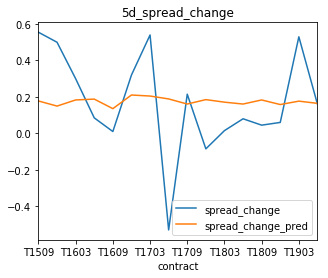

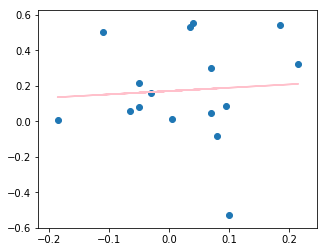

feature:  10d_spread_change
0.013963498168541035


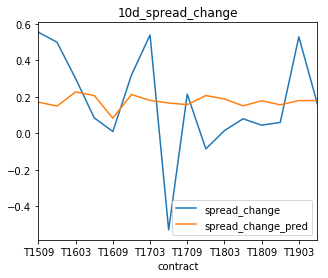

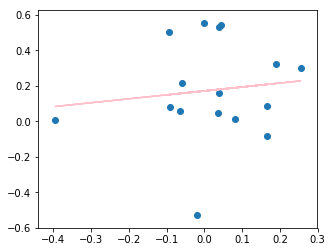

feature:  15d_spread_change
0.08490320685400099


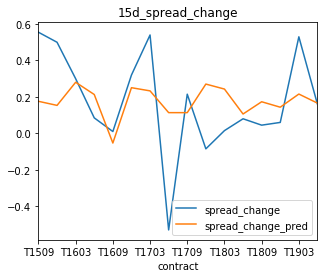

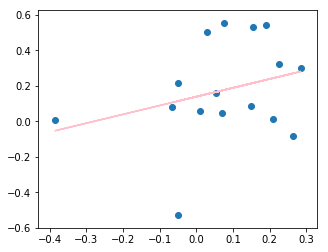

feature:  20d_spread_change
0.10589376538847872


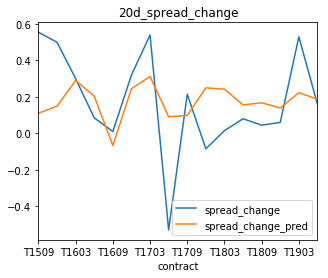

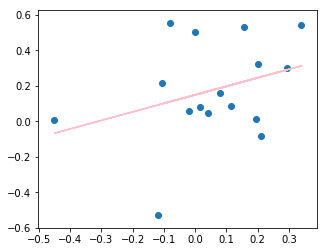

feature:  10d_act_price_exp_mva
0.08174146678637095


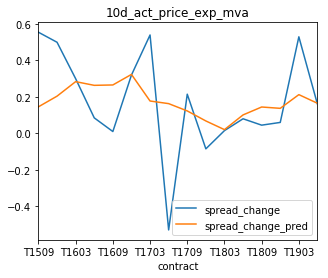

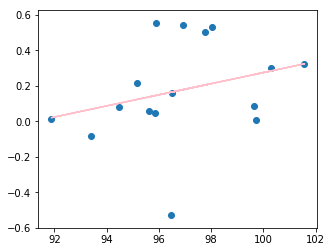

feature:  -1d_corr_act_price_def_OI
0.016555952626012616


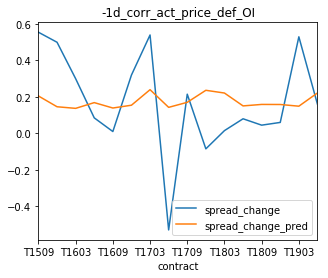

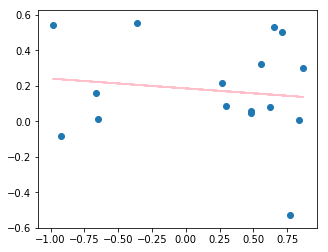

feature:  -1d_corr_def_price_def_OI
0.01931829720077527


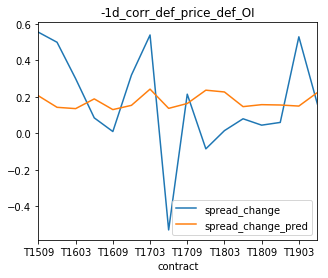

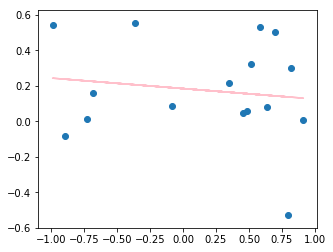

feature:  10d_spread_std_divided_by_std
0.0015785517898895263


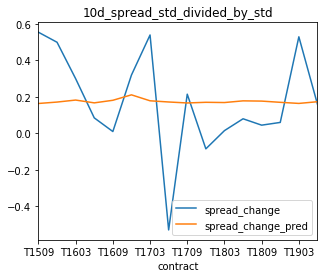

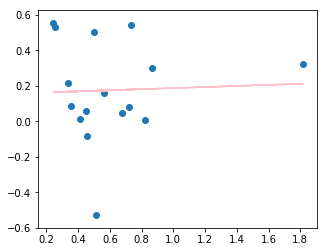

feature:  10d_current_price
0.0012721128650264868


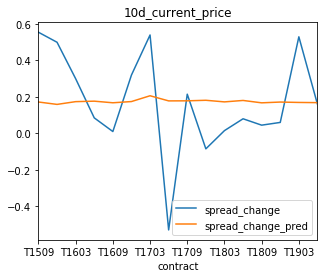

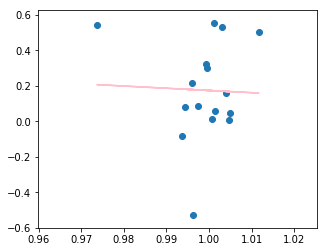

feature:  1d_z_diff_act_price_def_price
0.1666908950607775


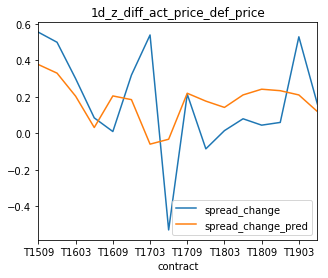

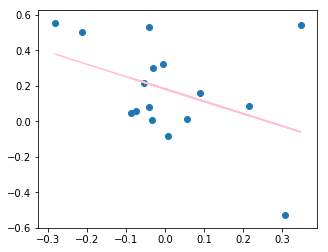

feature:  -1d_corr_act_price_def_volume
0.014353634494270517


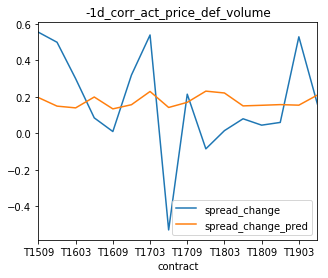

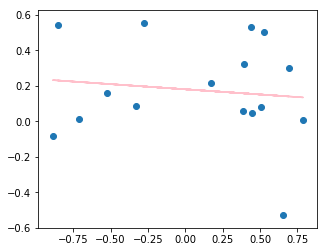

feature:  -1d_corr_def_price_def_volume
0.01558585707978122


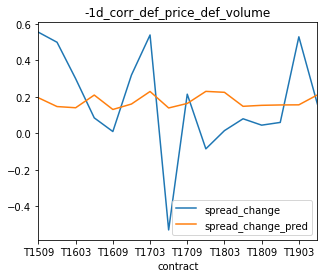

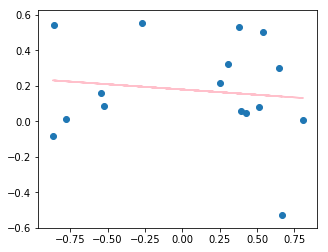

feature:  10d_current_spread
0.017892705732628356


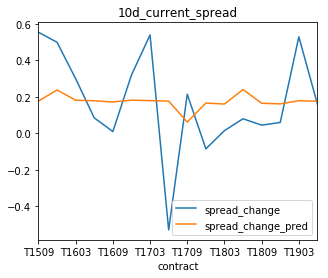

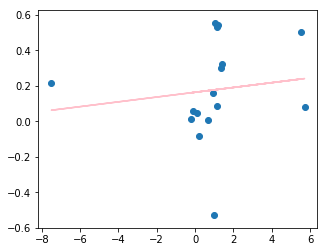

feature:  -1d_std
0.03899803248458156


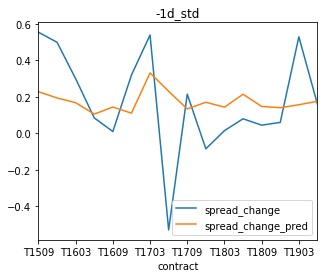

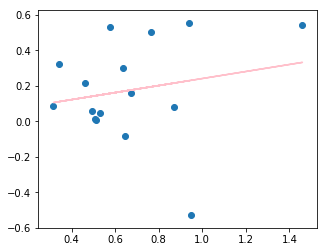

feature:  -1d_corr_act_price_def_price
0.013491533258446875


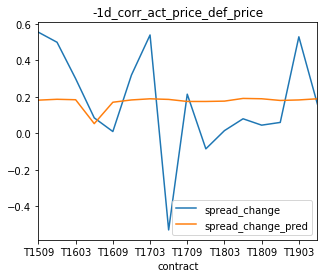

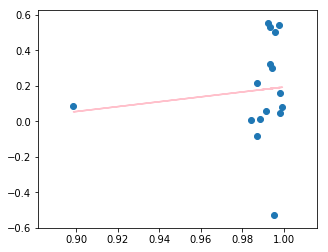

feature:  -1d_corr_act_OI_def_volume
0.006720884865607847


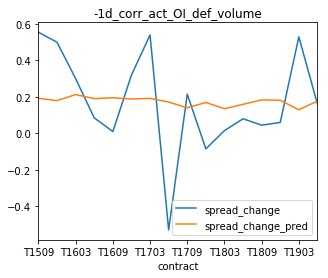

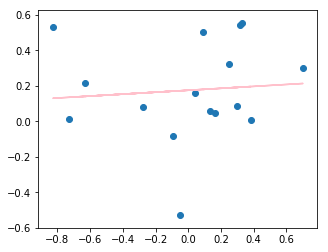

feature:  -1d_corr_act_OI_def_OI
0.0010967288240701922


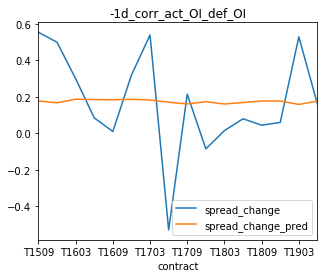

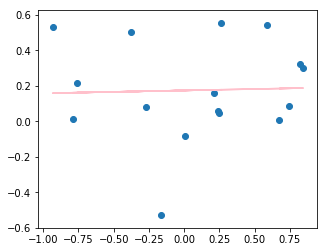

feature:  -1d_corr_def_volume_def_OI
0.009996433556656137


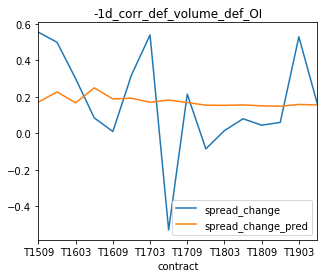

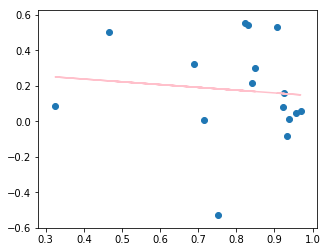

feature:  -1d_corr_def_OI_spread
0.2248521601444662


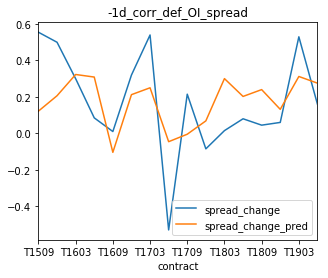

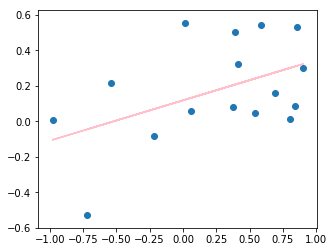

feature:  -1d_corr_def_volume_spread
0.15694937199469572


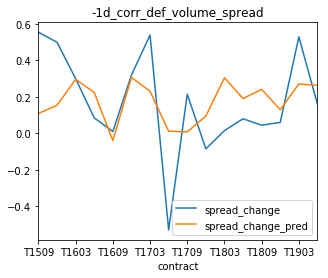

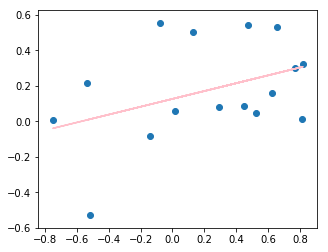

feature:  1d_z_diff_act_price_def_OI
0.10707139044465187


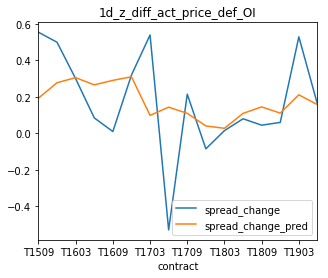

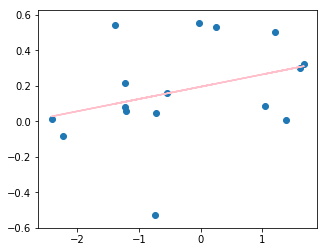

feature:  -1d_corr_act_volume_def_volume
0.003788083723607283


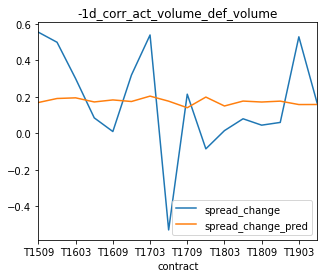

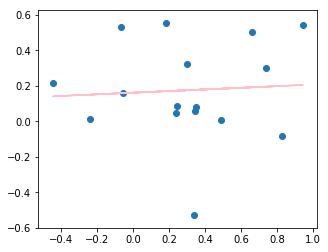

feature:  -1d_corr_act_volume_def_OI
0.03528395256102179


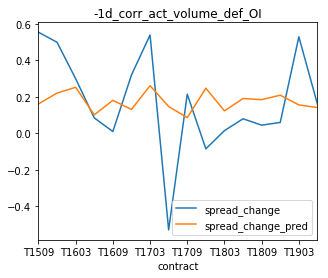

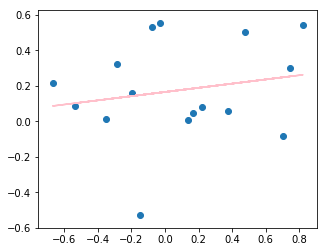

feature:  -1d_corr_act_price_act_OI
0.031178689474880894


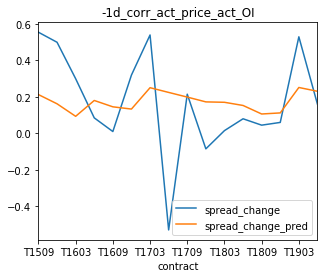

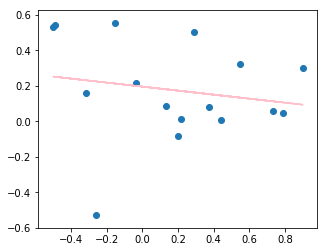

feature:  1d_z_diff_act_volume_act_OI
0.08621244641954362


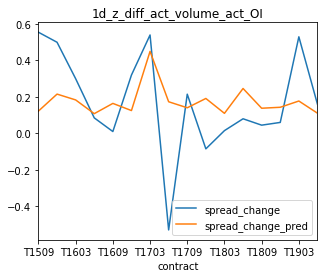

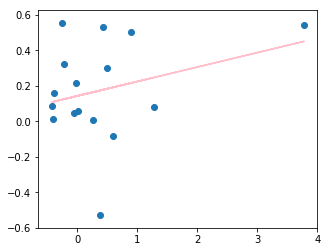

feature:  10d_def_volume_exp_mva
0.08755224925799843


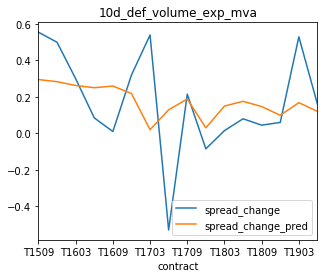

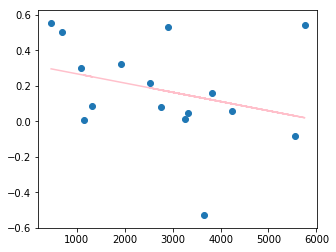

feature:  -1d_corr_act_OI_spread
0.00430894396243009


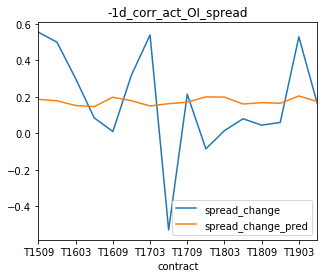

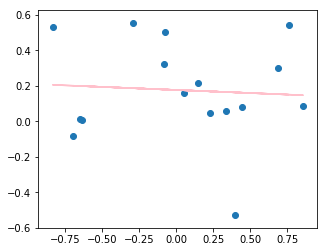

feature:  -1d_corr_def_price_spread
0.14076654740680605


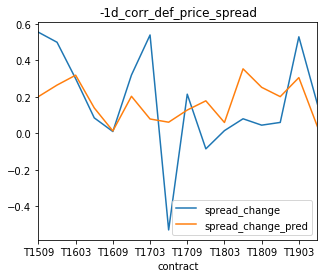

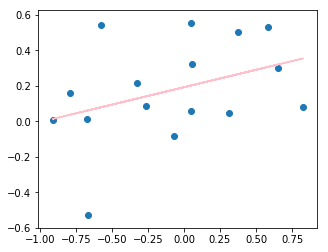

In [108]:
plt.rcParams['figure.figsize'] = [5, 4]
for feature in T_features.columns:
    print('feature: ', feature)
    x = T_features[feature].values.reshape(-1, 1)
    y = T_spread_change.values.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x, y)
    print(lr.score(x, y))
    y_pred = lr.predict(x)
    
    reg = T_spread_change.copy()
    reg['spread_change_pred'] = y_pred
    reg[['spread_change', 'spread_change_pred']].plot()
    plt.title(feature)
    plt.show()
    plt.scatter(x,y)
    plt.plot(x, y_pred, c='pink')
    plt.show()

In [109]:
T_tscore = pd.DataFrame(index=['t_value', 'p_value'], columns=T_features.columns)

for feature in T_features.columns:
    
    print('feature: ', feature)
    x = T_features[feature].values.reshape(-1, 1)
    y = T_spread_change.values.reshape(-1, 1)
    
    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    
    print(est2.summary())
    print()
    
    T_tscore.loc['t_value', feature] = est2.tvalues[1]
    T_tscore.loc['p_value', feature] = est2.pvalues[1]
    print()

feature:  5d_spread_change
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.066
Method:                 Least Squares   F-statistic:                   0.06671
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.800
Time:                        16:00:48   Log-Likelihood:                -2.0254
No. Observations:                  16   AIC:                             8.051
Df Residuals:                      14   BIC:                             9.596
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1703    

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stat

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.343
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.266
Time:                        16:00:48   Log-Likelihood:                -1.3305
No. Observations:                  16   AIC:                             6.661
Df Residuals:                      14   BIC:                             8.206
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3193      0.143      2.233      0.0

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [110]:
T_tscore.to_csv('T_tscore.csv')

In [111]:
T_tscore#.loc['p_value', :]

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,...,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI,10d_def_volume_exp_mva,-1d_corr_act_OI_spread,-1d_corr_def_price_spread
t_value,0.258276,0.445261,1.13971,1.28767,1.11636,-0.485474,-0.525151,0.148777,-0.133538,-1.67347,...,2.01521,1.61442,1.29566,0.230727,0.715571,-0.67123,1.14928,-1.15903,-0.246143,1.51446
p_value,0.799952,0.662938,0.273534,0.21874,0.283064,0.634849,0.607695,0.883851,0.895669,0.116423,...,0.0635005,0.128741,0.216047,0.820865,0.48602,0.512998,0.269696,0.265833,0.809144,0.152156


feature:  5d_spread_change
0.10719502141142435


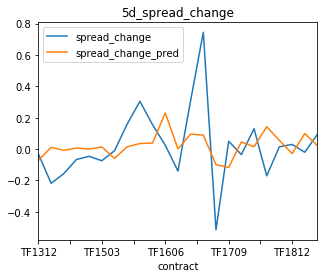

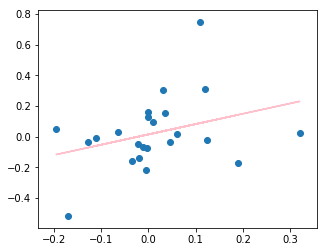

feature:  10d_spread_change
0.22965779611306048


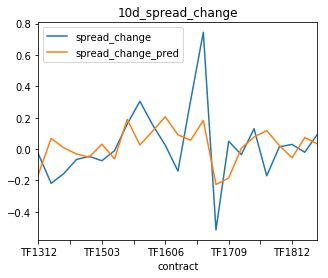

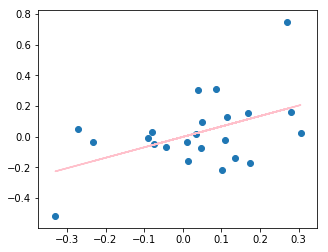

feature:  15d_spread_change
0.186724655195613


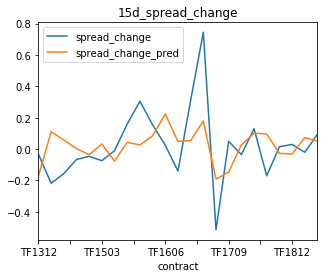

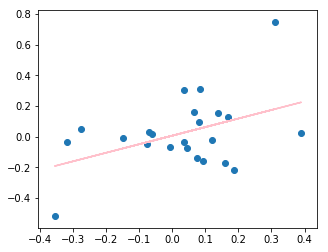

feature:  20d_spread_change
0.21029481383865187


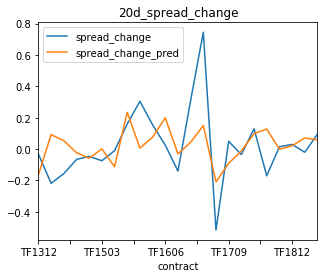

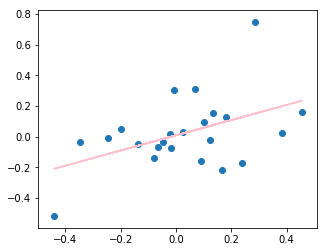

feature:  10d_act_price_exp_mva
0.11533324387773268


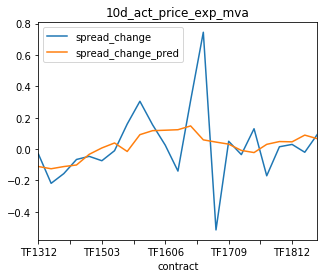

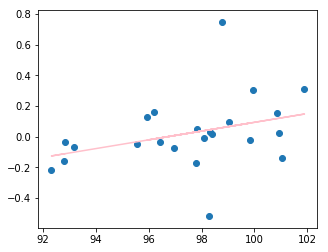

feature:  -1d_corr_act_price_def_OI
0.032013540803200735


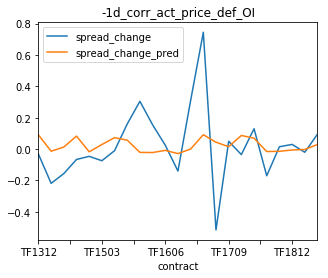

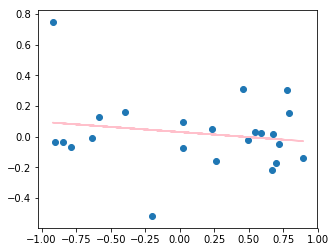

feature:  -1d_corr_def_price_def_OI
0.06006705911085042


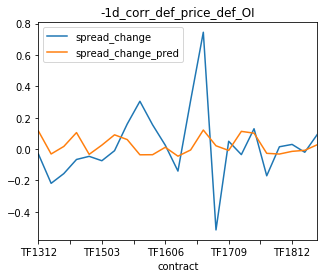

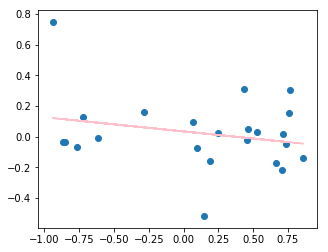

feature:  10d_spread_std_divided_by_std
0.07983583135199501


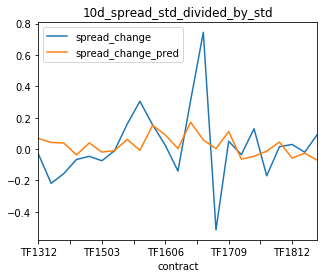

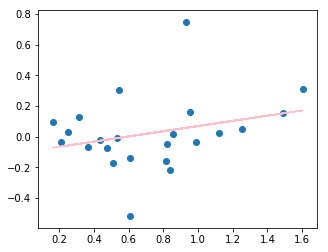

feature:  10d_current_price
0.08013145060604498


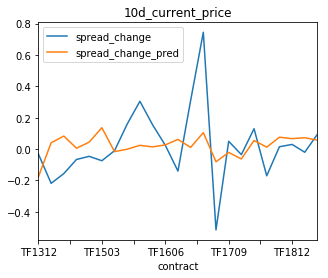

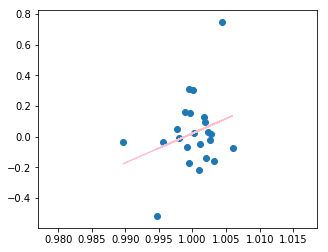

feature:  1d_z_diff_act_price_def_price
0.0013917341987743637


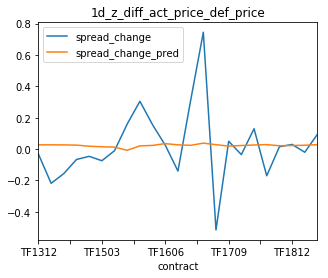

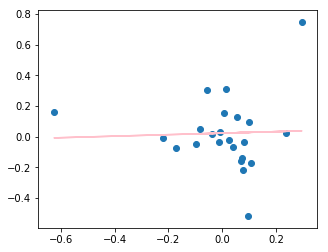

feature:  -1d_corr_act_price_def_volume
0.022912692424387426


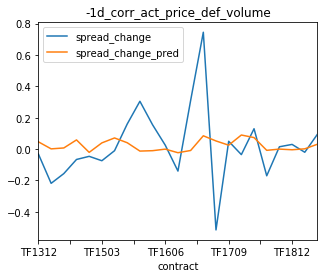

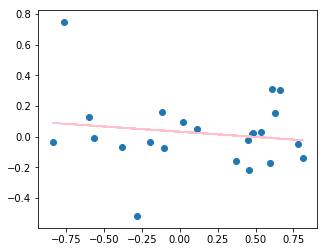

feature:  -1d_corr_def_price_def_volume
0.051019462395740844


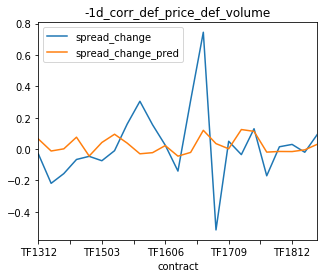

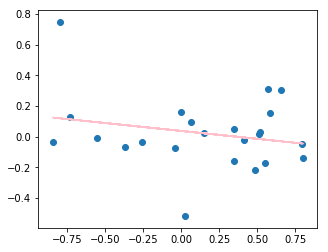

feature:  10d_current_spread
0.0696639397247355


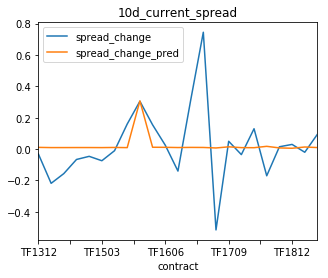

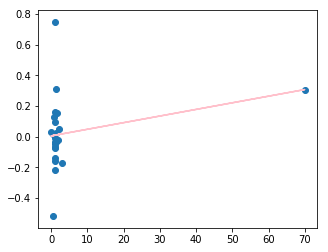

feature:  -1d_std
0.11014868907854913


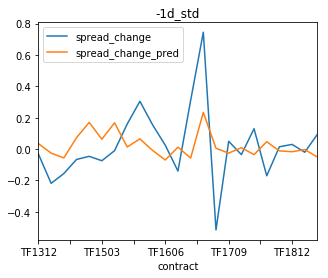

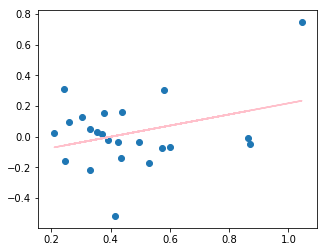

feature:  -1d_corr_act_price_def_price
0.00807440685572014


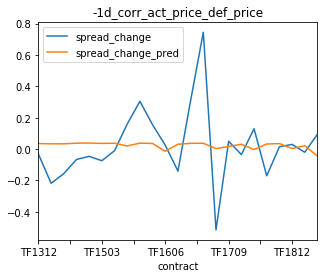

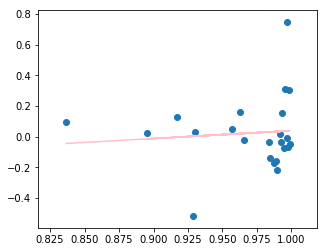

feature:  -1d_corr_act_OI_def_volume
0.0015354825567494013


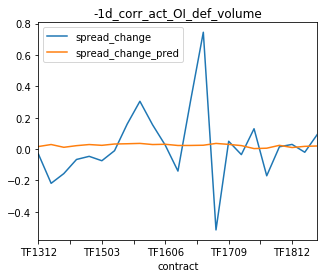

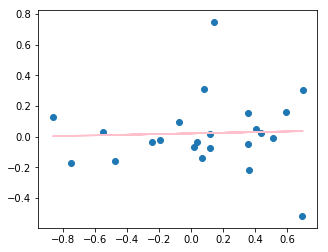

feature:  -1d_corr_act_OI_def_OI
0.006310539697918949


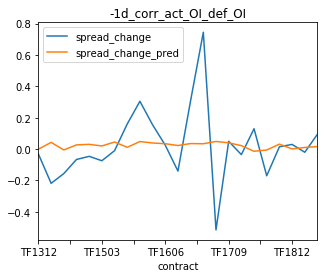

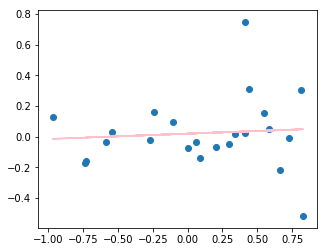

feature:  -1d_corr_def_volume_def_OI
0.006395451354069159


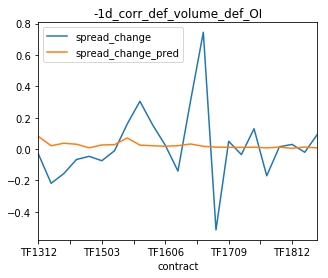

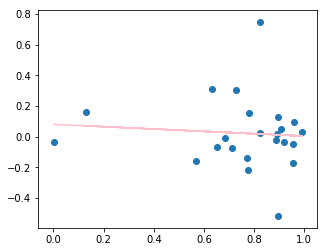

feature:  -1d_corr_def_OI_spread
0.19648539290174738


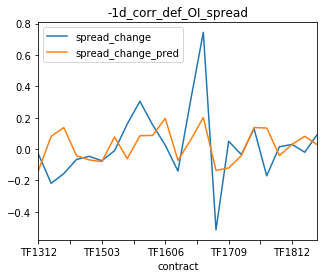

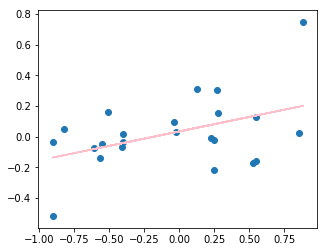

feature:  -1d_corr_def_volume_spread
0.22122592229815563


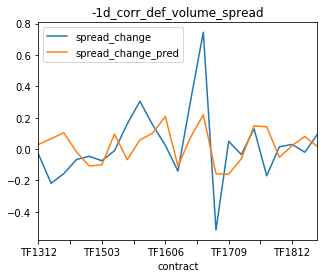

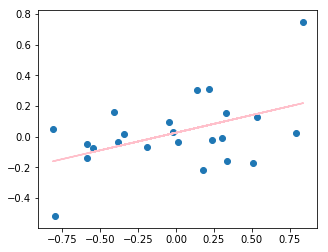

feature:  1d_z_diff_act_price_def_OI
0.10806431032281727


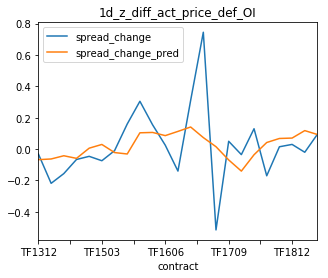

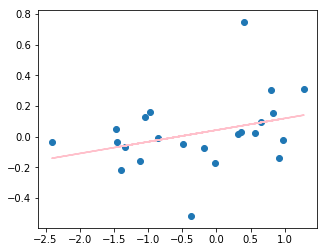

feature:  -1d_corr_act_volume_def_volume
0.0818857685733505


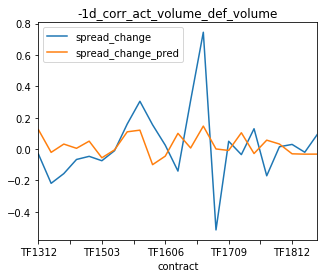

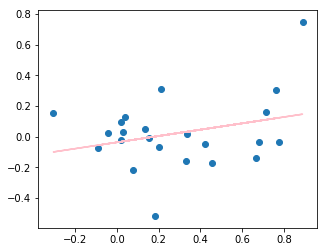

feature:  -1d_corr_act_volume_def_OI
0.12463517365172082


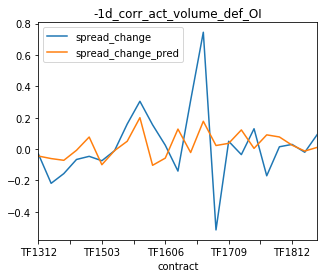

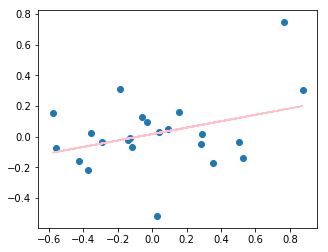

feature:  -1d_corr_act_price_act_OI
0.00853815097039956


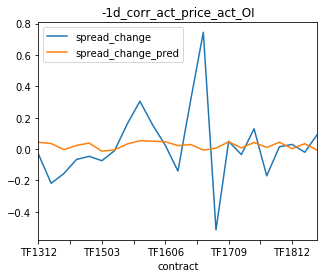

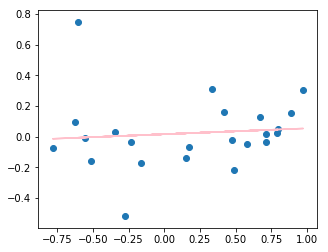

feature:  1d_z_diff_act_volume_act_OI
0.053909222810416095


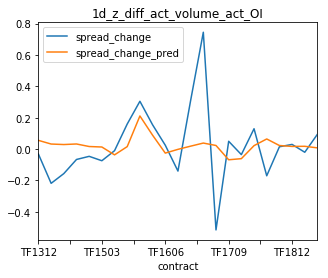

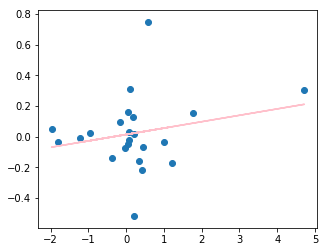

feature:  10d_def_volume_exp_mva
0.05486071921977265


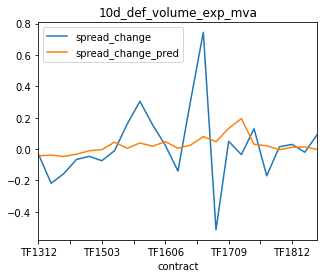

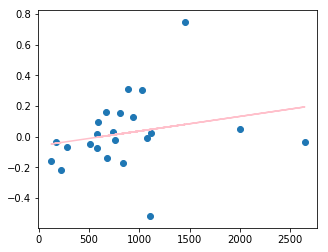

feature:  -1d_corr_act_OI_spread
0.08828241144334437


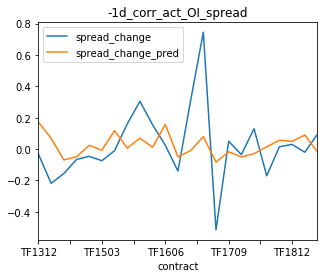

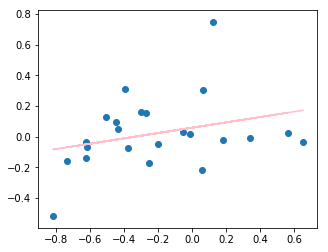

feature:  -1d_corr_def_price_spread
0.10728885274532717


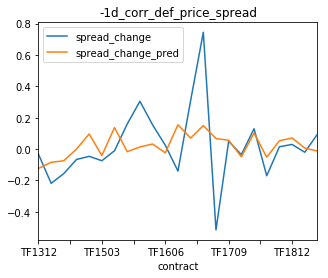

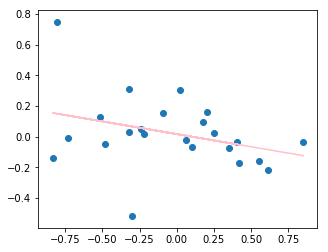

In [112]:
plt.rcParams['figure.figsize'] = [5, 4]
for feature in TF_features.columns:
    print('feature: ', feature)
    x = TF_features[feature].values.reshape(-1, 1)
    y = TF_spread_change.values.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x, y)
    print(lr.score(x, y))
    y_pred = lr.predict(x)
    
    reg = TF_spread_change.copy()
    reg['spread_change_pred'] = y_pred
    reg[['spread_change', 'spread_change_pred']].plot()
    plt.title(feature)
    plt.show()
    plt.scatter(x,y)
    plt.plot(x, y_pred, c='pink')
    plt.show()

In [113]:
TF_tscore = pd.DataFrame(index=['t_value', 'p_value'], columns=TF_features.columns)

for feature in TF_features.columns:
    
    print('feature: ', feature)
    x = TF_features[feature].values.reshape(-1, 1)
    y = TF_spread_change.values.reshape(-1, 1)
    
    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    
    print(est2.summary())
    print()
    
    TF_tscore.loc['t_value', feature] = est2.tvalues[1]
    TF_tscore.loc['p_value', feature] = est2.pvalues[1]
    print()

feature:  5d_spread_change
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.521
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.127
Time:                        16:00:55   Log-Likelihood:                 2.5188
No. Observations:                  23   AIC:                            -1.038
Df Residuals:                      21   BIC:                             1.233
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152    

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


feature:  1d_z_diff_act_volume_act_OI
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.197
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.286
Time:                        16:00:55   Log-Likelihood:                 1.8521
No. Observations:                  23   AIC:                            0.2958
Df Residuals:                      21   BIC:                             2.567
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]

In [114]:
TF_tscore.to_csv('TF_tscore.csv')

In [115]:
TF_tscore

,5d_spread_change,10d_spread_change,15d_spread_change,20d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,...,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI,10d_def_volume_exp_mva,-1d_corr_act_OI_spread,-1d_corr_def_price_spread
t_value,1.58788,2.50212,2.19579,2.36478,1.65462,-0.833378,-1.15846,1.34982,1.35253,0.171076,...,2.26609,2.44243,1.59509,1.36857,1.72916,0.425259,1.09389,1.10406,1.42599,-1.58866
p_value,0.127256,0.0206832,0.0394801,0.0277471,0.112873,0.41401,0.259683,0.191445,0.19059,0.865801,...,0.0341356,0.0235181,0.125633,0.185599,0.0984549,0.674974,0.286391,0.282058,0.168568,0.12708


## Lasso Regression

In [116]:
from sklearn.linear_model import Lasso

### T

In [117]:
T_features.columns

Index(['5d_spread_change', '10d_spread_change', '15d_spread_change',
       '20d_spread_change', '10d_act_price_exp_mva',
       '-1d_corr_act_price_def_OI', '-1d_corr_def_price_def_OI',
       '10d_spread_std_divided_by_std', '10d_current_price',
       '1d_z_diff_act_price_def_price', '-1d_corr_act_price_def_volume',
       '-1d_corr_def_price_def_volume', '10d_current_spread', '-1d_std',
       '-1d_corr_act_price_def_price', '-1d_corr_act_OI_def_volume',
       '-1d_corr_act_OI_def_OI', '-1d_corr_def_volume_def_OI',
       '-1d_corr_def_OI_spread', '-1d_corr_def_volume_spread',
       '1d_z_diff_act_price_def_OI', '-1d_corr_act_volume_def_volume',
       '-1d_corr_act_volume_def_OI', '-1d_corr_act_price_act_OI',
       '1d_z_diff_act_volume_act_OI', '10d_def_volume_exp_mva',
       '-1d_corr_act_OI_spread', '-1d_corr_def_price_spread'],
      dtype='object')

In [118]:
x = T_features.values
y = T_spread_change.values

alphas = [0.001, 0.002, 0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
for alpha in alphas:
    lasso = Lasso(alpha=alpha, normalize=True)
    lasso.fit(x, y)
    print(alpha, '-------', lasso.score(x, y))
    print(lasso.sparse_coef_)
    print()
    #print(np.count_nonzero(lasso.sparse_coef_.toarray()))

0.001 ------- 0.9838853639232058
  (0, 4)	0.056523538522837875
  (0, 8)	-0.23140886289345894
  (0, 9)	-1.497523338162668
  (0, 11)	-0.13684548327284324
  (0, 12)	-0.015736349110048106
  (0, 18)	0.18606457865691148
  (0, 21)	-0.144210137139139
  (0, 23)	-0.14486226208817718
  (0, 24)	0.19009092569178507
  (0, 25)	-8.78072017403469e-06
  (0, 27)	-0.02296565456756449

0.002 ------- 0.9683978363766902
  (0, 4)	0.05014880153232818
  (0, 6)	-0.031884526224549646
  (0, 9)	-1.3596435882745663
  (0, 11)	-0.08391227657914334
  (0, 12)	-0.016337917883075818
  (0, 18)	0.18435106821909122
  (0, 21)	-0.08502305090920695
  (0, 23)	-0.15995663089406378
  (0, 24)	0.16412185395727286
  (0, 25)	-1.0608228479935259e-05

0.005 ------- 0.8932568523281945
  (0, 4)	0.03630836877002473
  (0, 6)	-0.03944642668793125
  (0, 9)	-1.1392608737275
  (0, 10)	-0.013605742258487858
  (0, 12)	-0.010477980482812713
  (0, 18)	0.18596754727546633
  (0, 23)	-0.16897003221801113
  (0, 24)	0.11197699250521262
  (0, 25)	-3.7214

In [119]:
T_tscore.iloc[:, 9]

t_value    -1.67347
p_value    0.116423
Name: 1d_z_diff_act_price_def_price, dtype: object

In [120]:
T_tscore.iloc[:, 18]

t_value      2.01521
p_value    0.0635005
Name: -1d_corr_def_OI_spread, dtype: object

In [121]:
T_tscore.iloc[:, 24]

t_value     1.14928
p_value    0.269696
Name: 1d_z_diff_act_volume_act_OI, dtype: object

In [122]:
T_features.iloc[:, [9, 24]].corr()

,1d_z_diff_act_price_def_price,1d_z_diff_act_volume_act_OI
1d_z_diff_act_price_def_price,1.000000,0.392621
1d_z_diff_act_volume_act_OI,0.392621,1.000000


In [123]:
x = T_features.iloc[:, 18].values
y = T_spread_change.values

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     4.061
Date:                Mon, 05 Aug 2019   Prob (F-statistic):             0.0635
Time:                        16:00:55   Log-Likelihood:              -0.025840
No. Observations:                  16   AIC:                             4.052
Df Residuals:                      14   BIC:                             5.597
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1180      0.071      1.669      0.1

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


### TF

In [124]:
x = TF_features.values
y = TF_spread_change.values

alphas = [0.001, 0.002, 0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
for alpha in alphas:
    lasso = Lasso(alpha=alpha, normalize=True)
    lasso.fit(x, y)
    print(alpha, '-------', lasso.score(x, y))
    print(lasso.sparse_coef_)
    print()
    #print(np.count_nonzero(lasso.sparse_coef_.toarray()))

0.001 ------- 0.8915867262224376
  (0, 0)	-0.4627060880012578
  (0, 3)	0.3058412955933022
  (0, 6)	-0.23629813350848333
  (0, 7)	0.2971932524008261
  (0, 8)	24.288792773380624
  (0, 9)	-0.009853675523339338
  (0, 12)	0.0041320608397703495
  (0, 13)	0.06557592590100968
  (0, 15)	-0.0808263541014358
  (0, 20)	0.0826888622105274
  (0, 22)	0.13677249510894476
  (0, 23)	0.01623621231036796
  (0, 25)	7.250100156369456e-05
  (0, 26)	0.08753629705378825

0.002 ------- 0.8430791923275519
  (0, 0)	-0.09501695054625715
  (0, 3)	0.2255088694208228
  (0, 6)	-0.21168622507786433
  (0, 7)	0.2684805964348491
  (0, 8)	20.526303948431877
  (0, 12)	0.0039177986406190735
  (0, 13)	0.025313260154834764
  (0, 15)	-0.040861404697718796
  (0, 20)	0.05464549559381235
  (0, 22)	0.13261332669305248
  (0, 25)	3.938348728861485e-05
  (0, 26)	0.07104154360663885
  (0, 27)	-0.029105852532757975

0.005 ------- 0.7104194953994796
  (0, 3)	0.22632891766461283
  (0, 4)	0.003604265009029703
  (0, 6)	-0.12633397344562
  (

In [125]:
TF_tscore.iloc[:, 1]

t_value      2.50212
p_value    0.0206832
Name: 10d_spread_change, dtype: object

In [126]:
TF_tscore.iloc[:, 19]

t_value      2.44243
p_value    0.0235181
Name: -1d_corr_def_volume_spread, dtype: object

In [127]:
TF_tscore.iloc[:, 22]

t_value      1.72916
p_value    0.0984549
Name: -1d_corr_act_volume_def_OI, dtype: object

In [128]:
TF_tscore.iloc[:, 27]

t_value   -1.58866
p_value    0.12708
Name: -1d_corr_def_price_spread, dtype: object

In [129]:
np.corrcoef(TF_features.iloc[:, 22].values, TF_features.iloc[:, 27].values)

array([[ 1.        , -0.40868652],
       [-0.40868652,  1.        ]])

In [130]:
x = TF_features.iloc[:, 19].values # 1, 11, 17, 20, 25
y = TF_spread_change.values

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     5.965
Date:                Mon, 05 Aug 2019   Prob (F-statistic):             0.0235
Time:                        16:00:55   Log-Likelihood:                 4.0902
No. Observations:                  23   AIC:                            -4.180
Df Residuals:                      21   BIC:                            -1.909
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0266      0.044      0.602      0.5